In [1]:
%load_ext autoreload
%autoreload 2

# Prescribed Fire Policy replication plots

In this notebook we generate the main plot of our simulations results and some supplementary figures explaining the simulation process: 
 - Fig S10: Low-severity wildfires are comparable to prescribed fires in severity
 - Fig S9: Relationship between fire severity and attributed smoke $PM_{2.5}$ (Panel A and B)
 - Fig 4: Cumulative benefit-cost ratio of prescribed burning
 - Fig S15: Benefit cost ratio for different discount rates
 - Fig 5: Large-scale prescribed burning reduces future burned area and wildfire smoke $PM_{2.5}$ (Panel C)
 - Fig 8: Low-severity treatment simulation (Panel A, B, and C)
 - Fig 5: Large-scale prescribed burning reduces future burned area and wildfire smoke $PM_{2.5}$ (Panel A and B)
 - Fig S13: Limits to prescribed fire treatments with spillovers ($\leq$ 2 km)
 - Fig S14: Emissions Net Benefit ratios by spillover treatments


In [2]:
import os

import duckdb
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from prescribed.estimate.simulations import (
    calculate_benefits,
    make_model,
)
from prescribed.plot import template_plots

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Path for data
data_path = "/mnt/sherlock/oak/prescribed_data/"
sim_path = "/mnt/sherlock/oak/prescribed_data/results/simulations"

# Set seed for reproducibility
np.random.seed(42)

How can we translate the policy in acres to our model parameters? We have to define the size of the treatments and the number of them to know how many 1 sq-km grids we need 

In [3]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(
    f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km"
)
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


## Load data (severity and MTBS)

In [4]:
# Load DNBR data and save to parquet to make it nicer for DuckDB
dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee_inmediate/dnbr_long.feather")
).drop(columns=["spatial_ref"], errors="ignore")

# Bottom code the negative dnbr to be zero if negative
# dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Load MTBS dataset to add year to the DNBR data
mtbs = (
    gpd.read_file(
        os.path.join(
            data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
        )
    )
    .to_crs("EPSG:3310")
    .drop(columns=["spatial_ref"], errors="ignore")
)

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)
dnbr.drop(columns=["Event_ID"], inplace=True)
dnbr.to_parquet("../data/dnbr.parquet")


# Because of some dnbr issues (buffered data), we need to remove some of the
# data by using the templates we have from MTBS (remove grids in the buffer).
# We could normally do this by a spatial join, but we have a lot of data and
# it's slow.
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")

treatments_dnbr = treatments.merge(
    dnbr[["year", "dnbr", "lat", "lon", "grid_id"]],
    left_on=["lat", "lon", "year"],
    right_on=["lat", "lon", "year"],
    how="left",
)

# Clean treatments to only be in Event ID in California and have data
treatments_dnbr = treatments_dnbr[
    (treatments_dnbr.Event_ID.str.startswith("CA"))
    & (~treatments_dnbr.dnbr.isna())
]

# Add land type data
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)
treatments_dnbr = treatments_dnbr.merge(
    land_type[["grid_id", "land_type"]], on="grid_id", how="left"
)

# Clean repeated observations for the same fire
treatments_dnbr_clean = treatments_dnbr.groupby(
    [
        "year",
        "Event_ID",
        "Incid_Name",
        "grid_id",
        "Ig_Date",
        "Incid_Type",
        "land_type",
    ],
    as_index=False,
).dnbr.mean()

## Some nice stats from the data

### 1. Fire probabilities

In [5]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Wildfire")
    & (mtbs.Ig_Date.dt.year >= 2010)
].Event_ID.tolist()

treatments["year"] = treatments.Ig_Date.dt.year

probs = (
    treatments[treatments.Event_ID.isin(wildfires_list)].groupby("year").size()
    / 103475  # total conifer grids in CA
).reset_index()
probs.rename(columns={0: "fire"}, inplace=True)

probs["num_fires"] = (
    mtbs[mtbs.Event_ID.isin(wildfires_list)].groupby("year").size().values
)

probs.to_csv("../data/results/probability_conifer_fire.csv", index=False)

In [6]:
probs = (
    treatments[treatments.Ig_Date.dt.year > 2010]
    .groupby(treatments.Ig_Date.dt.year, as_index=False)
    .size()
)

probs["fire"] = probs["size"] / 103475
probs.rename(columns={"Ig_Date": "year"}, inplace=True)
probs.to_csv("../data/results/probability_conifer_fire.csv", index=False)

### 2. Average severity for Rx fire and average observed severity

In [7]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Prescribed Fire")
].Event_ID.tolist()

dnbr[
    (dnbr.event_id.isin(wildfires_list))
    & (dnbr.grid_id.isin(land_type[land_type.land_type == 2].grid_id.tolist()))
].dnbr.mean()

44.914364

In [8]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Wildfire")
    & (mtbs.Ig_Date.dt.year >= 2010)
].Event_ID.tolist()

dnbr[(dnbr.event_id.isin(wildfires_list))].groupby(
    "year", as_index=False
).dnbr.mean().to_csv("../data/results/dnbr_values_year.csv", index=False)

## Fig S10: Low-severity wildfires are comparable to prescribed fires in severity

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_

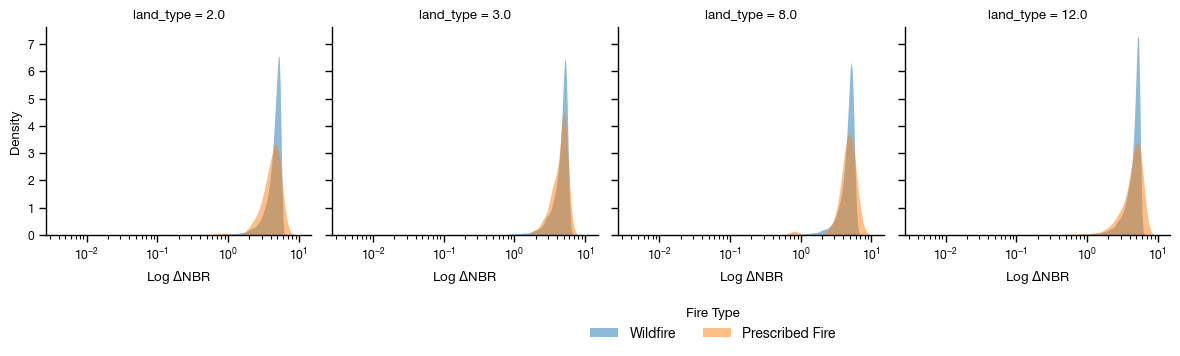

In [9]:
land_types = {
    2.0: "conifers",
    12.0: "shrublands",
    3.0: "conifer-hardwood",
    8.0: "hardwood",
}


# Subset to get only conifers!
plot_data = treatments_dnbr_clean[
    treatments_dnbr_clean.land_type.isin(land_types.keys())
]

plot_data = plot_data[
    plot_data.Event_ID.isin(
        mtbs[
            mtbs.Incid_Type.isin(["Prescribed Fire", "Wildfire"])
        ].Event_ID.tolist()
    )
]

# Filter all Wildifre observations whose dnbr is larger than 269
plot_data = plot_data[
    ~((plot_data.Incid_Type == "Wildfire") & (plot_data.dnbr > 269))
]
plot_data["log_dnbr"] = np.log(plot_data.dnbr)

sns.set_context("paper")
g = sns.FacetGrid(data=plot_data, col="land_type", hue="Incid_Type")

g.map(
    sns.kdeplot,
    "log_dnbr",
    fill=True,
    alpha=0.5,
    linewidth=0,
    log_scale=True,
    palette=["#FF7F0E", "#1F77B4"],
    common_norm=False,
    multiple="layer",
    hue_order=["Wildfire", "Prescribed Fire"],
)

# Add legend at the bottom of the plot
g.add_legend(
    title="Fire Type",
    bbox_to_anchor=(0.5, 0.0),
    loc="upper center",
    ncol=2,
    fontsize=10,
)
g.set_axis_labels(r"Log $\Delta$NBR", "Density")

# Save as a PDF
plt.savefig(
    "../figs/dnbr_rx_lowseverity.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## Fig S9: Relationship between fire severity and attributed smoke PM (Panel A)

Degree 1: RMSE = 16615.9906, R2 = 0.5055
Degree 2: RMSE = 17194.2856, R2 = 0.4705
Degree 3: RMSE = 17957.0801, R2 = 0.4224
Degree 4: RMSE = 18023.4625, R2 = 0.4182
Degree 5: RMSE = 20005.4050, R2 = 0.2832
Degree 6: RMSE = 21000.4140, R2 = 0.2101
Degree 7: RMSE = 22014.7314, R2 = 0.1319
Degree 8: RMSE = 22870.3600, R2 = 0.0632


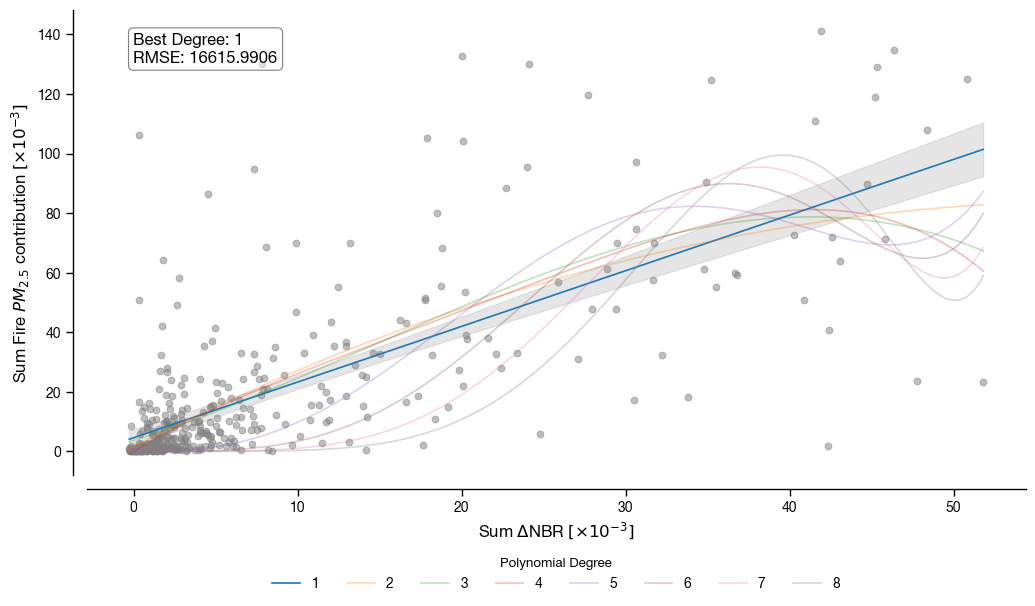

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


def find_best_polynomial_fit(
    data,
    x_col,
    y_col,
    degrees=range(1, 9),
    test_size=0.2,
    random_state=42,
    remove_outliers=False,
    quantile_range=(0.025, 0.975),
):
    """
    Finds the best polynomial fit between two columns in a DataFrame using RMSE and R-squared.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing the data.
    x_col : str
        The name of the column to use as the independent variable.
    y_col : str
        The name of the column to use as the dependent variable.
    degrees : range, optional
        The range of polynomial degrees to test, by default range(1, 9).
    test_size : float, optional
        The proportion of the data to use as the test set, by default 0.2.
    random_state : int, optional
        The random seed for reproducibility, by default 42.
    remove_outliers : bool, optional
        Whether to remove outliers from the data, by default False.
    quantile_range : tuple, optional
        The lower and upper quantiles to use for outlier removal, by default (0.025, 0.975).

    Returns
    -------
    None
    """
    # Optionally remove outliers
    if remove_outliers:
        lower_x, upper_x = data[x_col].quantile(quantile_range)
        lower_y, upper_y = data[y_col].quantile(quantile_range)
        data = data[
            (data[x_col] >= lower_x)
            & (data[x_col] <= upper_x)
            & (data[y_col] >= lower_y)
            & (data[y_col] <= upper_y)
        ]

    # Split the data into train and test sets
    X = data[[x_col]].values
    y = data[y_col].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Store RMSE and R-squared values for each degree
    rmse_scores = []
    r2_scores = []

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X / 1000, y / 1000, color="gray", alpha=0.5)

    # Loop through polynomial degrees
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Fit the model using statsmodels
        model = sm.OLS(y_train, X_train_poly).fit()

        # Predict on the test set
        y_pred = model.predict(X_test_poly)

        # Calculate RMSE
        residuals = y_test - y_pred
        rmse = np.sqrt(np.mean(residuals**2))
        rmse_scores.append((degree, rmse))

        # Calculate R-squared
        ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
        ss_residual = np.sum(residuals**2)
        r2 = 1 - (ss_residual / ss_total)
        r2_scores.append((degree, r2))

        # Plot the fit
        X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
        X_plot_poly = poly.transform(X_plot)
        y_plot = model.predict(X_plot_poly)
        ax.plot(
            X_plot / 1000,
            y_plot / 1000,
            label=f"{degree}",
            alpha=1 if degree == 1 else 0.3,
        )

        # Calculate confidence intervals for the predictions
        if degree == 1:
            predictions = model.get_prediction(X_plot_poly)
            ci = predictions.conf_int(alpha=0.05)
            ci_lower = ci[:, 0]
            ci_upper = ci[:, 1]
            ax.fill_between(
                X_plot.squeeze() / 1000,
                ci_lower / 1000,
                ci_upper / 1000,
                color="gray",
                alpha=0.2,
            )

    # Display RMSE and R-squared scores
    for degree, rmse, r2 in zip(degrees, rmse_scores, r2_scores):
        print(f"Degree {degree}: RMSE = {rmse[1]:.4f}, R2 = {r2[1]:.4f}")

    # Add best RMSE and degree to the plot as text
    best_degree = min(rmse_scores, key=lambda x: x[1])[0]
    best_rmse = min(rmse_scores, key=lambda x: x[1])[1]
    ax.text(
        0.05,
        0.95,
        f"Best Degree: {best_degree}\nRMSE: {best_rmse:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    # Move legend to the bottom of the plot outside the plotting area
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(degrees),
        fontsize=10,
        frameon=False,
        title="Polynomial Degree",
    )
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    template_plots(
        ax,
        xlab=r"Sum $\Delta$NBR $[\times 10^{-3}]$",
        ylab=r"Sum Fire $PM_{2.5}$ contribution $[\times 10^{-3}]$ ",
    )


smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked_new.feather"
)

# Filter by coverage threshold
smoke_linked = smoke_linked.loc[
    smoke_linked.groupby("event_id")["coverage_threshold"].idxmax()
]


# Assuming `smoke_linked` is your DataFrame
find_best_polynomial_fit(
    smoke_linked,
    x_col="sum_severity",
    y_col="sum_contrib",
    degrees=range(1, 9),
    remove_outliers=True,
    quantile_range=(0.025, 0.90),
)

# # Save the plot as a PDF
# plt.savefig(
#     "../figs/smoke_linked_polynomial_fit.pdf",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )

## Fig S9: Relationship between fire severity and attributed smoke PM (Panel B)

Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:40<00:00, 24.55it/s]
/tmp/ipykernel_1051858/3445240716.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_fires["sample"] = "All Fires"
/tmp/ipykernel_1051858/3445240716.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_fires["sample"] = "Matched Fires"


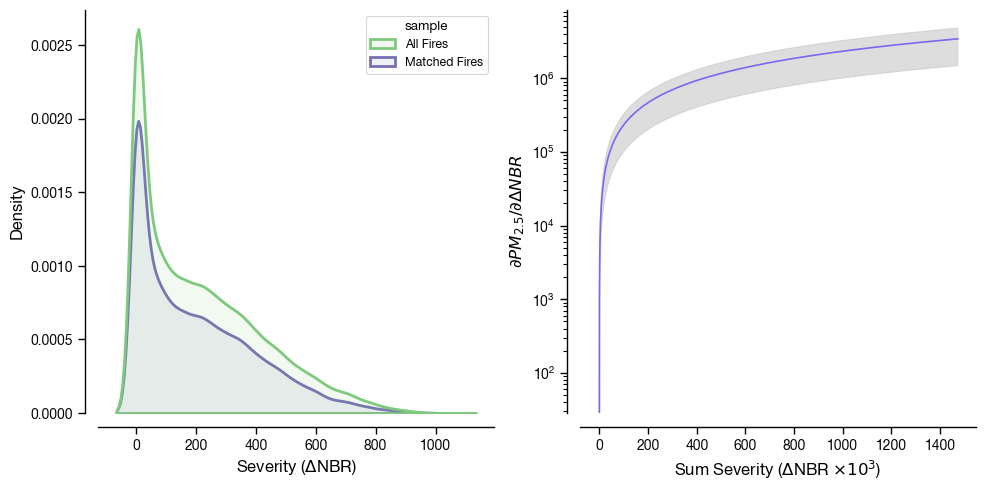

In [14]:
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked_new.feather"
)

# Filter by coverage threshold
smoke_linked = smoke_linked.loc[
    smoke_linked.groupby("event_id")["coverage_threshold"].idxmax()
]

# Change year type to avoid problems
smoke_linked["year"] = smoke_linked.year.astype(int)

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    k=999,
)

# Estimate boostrap confidence intervals for marginal effects

# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)

# Multiply the second column of coef by the range of severities
boot_samples = []
for i in range(999):
    boot_samples.append(coefs[i, 0] * range_severity)

boots = np.vstack(boot_samples)
bounds = np.percentile(boots, [2.5, 0.5, 97.5], axis=0)

# Plot the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create a dataframe to plot the density of the dnbr values for all fires
# and the matched fires

all_fires = treatments_dnbr_clean[treatments_dnbr_clean.year > 2006]
all_fires["sample"] = "All Fires"

matched_fires = treatments_dnbr_clean[
    (treatments_dnbr_clean.year > 2006)
    & (treatments_dnbr_clean.Event_ID.isin(smoke_linked.event_id.tolist()))
]
matched_fires["sample"] = "Matched Fires"
data_dist = pd.concat([all_fires, matched_fires])


sns.kdeplot(
    data=data_dist,
    x="dnbr",
    hue="sample",
    ax=ax[0],
    palette=["#7fc97f", "#7570b3"],
    common_norm=True,
    fill=True,
    linewidth=2,
    alpha=0.1,
)


# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")


# Plot marginal effect of severity on emissions using log scale
ax[1].set_yscale("log")
ax[1].fill_between(
    range_severity / 1000,
    bounds[0],
    bounds[2],
    alpha=0.5,
    color="#bdbdbd",
)

# Plot median prediction as a line
ax[1].plot(
    range_severity / 1000,
    np.mean(boots, axis=0),
    color="mediumslateblue",
)

# Apply template
template_plots(
    ax[1],
    xlab="Sum Severity ($\Delta$NBR $\\times 10^{3} $)",
    ylab="$\partial PM_{2.5} / \partial \Delta NBR$",
)

plt.tight_layout()

# Save as a PDF
plt.savefig(
    "../figs/severity_emissions_link.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


## Fig 4: Discounted benefit-cost ratio for two types of simulation (w/ and wo/ spillovers)

The objects created for this figure are also used in other derivative plots in the supplements. If you need to replicate others, you should run this one first. 

In [188]:
# Set seed numpy
np.random.seed(42)

# Load smoke link data
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked_new_inmediate.feather"
)

# Avoid prediction errors
smoke_linked["year"] = smoke_linked.year.astype(int)

# Filter by coverage threshold
smoke_linked = smoke_linked.loc[
    smoke_linked.groupby("event_id")["coverage_threshold"].idxmax()
]

benefits_no_spill, sims = calculate_benefits(
    n_treats=4000,
    path=f"{sim_path}/policy_no_spill_large_new_4000",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=60,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
)
benefits_no_spill["treatment"] = "No Spill"
benefits_no_spill["n_treats"] = 4000

bens_sims = []
bens_spill = []

for size in [500, 1000, 1500, 2000]:
    benefits_spill, sims_spill = calculate_benefits(
        n_treats=size,
        path=f"{sim_path}/policy_spill_large_new_new_{size}",
        discount_rates=[0.02, 0.04, 0.06, 0.1],
        treat_severity=60,
        average_treats=True,
        linked_data=smoke_linked,
        formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
        bootstrap=True,
        predict=True,
    )
    benefits_spill["treatment"] = "Spillovers"
    benefits_spill["n_treats"] = size

    sims_spill["n_treats"] = size

    bens_sims.append(sims_spill)
    bens_spill.append(benefits_spill)

bens_sims = pd.concat(bens_sims)
benefits_spill = pd.concat(bens_spill)
benefits = pd.concat([benefits_no_spill, benefits_spill])

Bootstrapping model results/coefficients: 100%|██████████| 1000/1000 [00:28<00:00, 34.99it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:505: UserWarning: 0.0897% of rows were removed
  prop = (
Bootstrapping model results/coefficients: 100%|██████████| 1000/1000 [00:28<00:00, 35.12it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:505: UserWarning: 0.1286% of rows were removed
  prop = (
Bootstrapping model results/coefficients: 100%|██████████| 1000/1000 [00:28<00:00, 35.15it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:505: UserWarning: 0.1524% of rows were removed
  prop = (
Bootstrapping model results/coefficients: 100%|██████████| 1000/1000 [00:28<00:00, 35.12it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:505: UserWarning: 0.2076% of rows were removed
  prop = (
Bootstrapping model results/coefficients: 100%|██████████| 1000/1000 [00:28<00:00, 35.12it/s]
/home/topcat/projects/

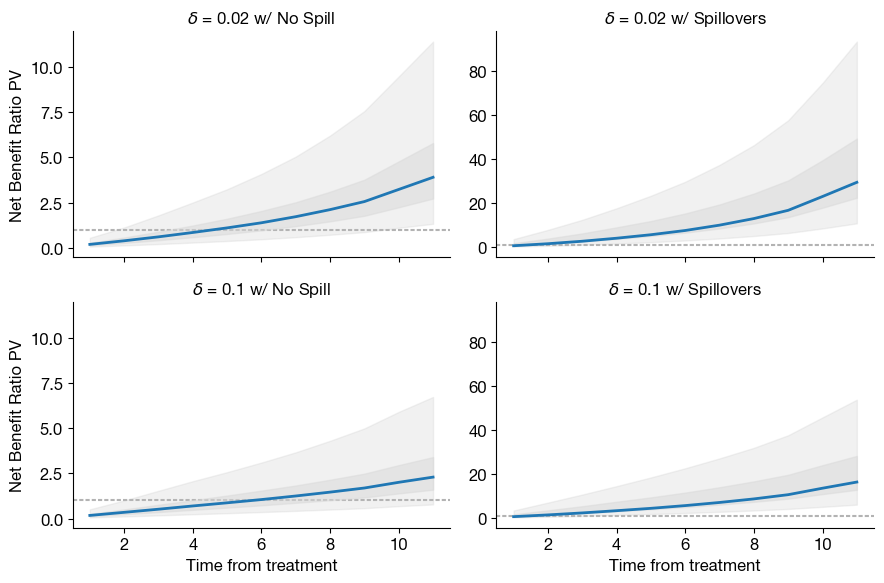

In [189]:
benefits_spill = pd.concat(bens_spill)
benefits = pd.concat([benefits_no_spill, benefits_spill])

# remove weird ratios
benefits = benefits.dropna()

# Select only the discount rates we want to plot
deltas = [0.02, 0.1]
benefits = benefits[benefits.discount_rate.isin(deltas)]

mean_benefits = (
    benefits.groupby(["lag", "discount_rate", "treatment", "n_treats"])
    .ratio.median()
    .reset_index()
)

g = sns.relplot(
    data=mean_benefits[mean_benefits.n_treats.isin([4_000, 2_000])],
    x="lag",
    y="ratio",
    row="discount_rate",
    col="treatment",
    kind="line",
    height=3,
    aspect=1.5,
    linewidth=2,
    zorder=5,
    legend=False,
    facet_kws={"sharey": "col", "sharex": True},
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$ = {row_name} w/ {col_name}")
    .tight_layout(w_pad=0)
)


# Plot the 0.25 and 0.975 quantiles for each discount rate and lag
iqr = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
ci = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.05, 0.95])
    .unstack()
    .reset_index()
)

stds = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.std(ddof=2)
    .reset_index()
)

ci_alt = pd.DataFrame(
    {
        "ci_low": mean_benefits.ratio - 1.96 * stds.ratio / np.sqrt(988),
        "ci_high": mean_benefits.ratio + 1.96 * stds.ratio / np.sqrt(988),
        "lag": mean_benefits.lag,
        "discount_rate": mean_benefits.discount_rate,
        "treatment": mean_benefits.treatment,
    }
)

for idxs, ax in g.axes_dict.items():
    dr, treat = idxs
    # Get the quantiles
    q_dr = ci[(ci.discount_rate == dr) & (ci.treatment == treat)]
    q_dr_iqr = iqr[(iqr.discount_rate == dr) & (iqr.treatment == treat)]

    ax.fill_between(
        q_dr.lag,
        q_dr[0.05],
        q_dr[0.95],
        color="#bdbdbd",
        alpha=0.2,
    )

    ax.fill_between(
        q_dr.lag,
        q_dr_iqr[0.25],
        q_dr_iqr[0.75],
        color="#d9d9d9",
        alpha=0.5,
    )

    # if treat == "Spillovers":
    # ax.set_yticks(np.arange(0, 100, 10))
    # ax.set_yticklabels(np.arange(0, 100, 10))


plt.tight_layout()

# # Save plot
# plt.savefig(
#     "../figs/pv_benefits_avg.pdf",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )
# plt.show()


## Fig S15: Benefit cost ratio for different discount rates

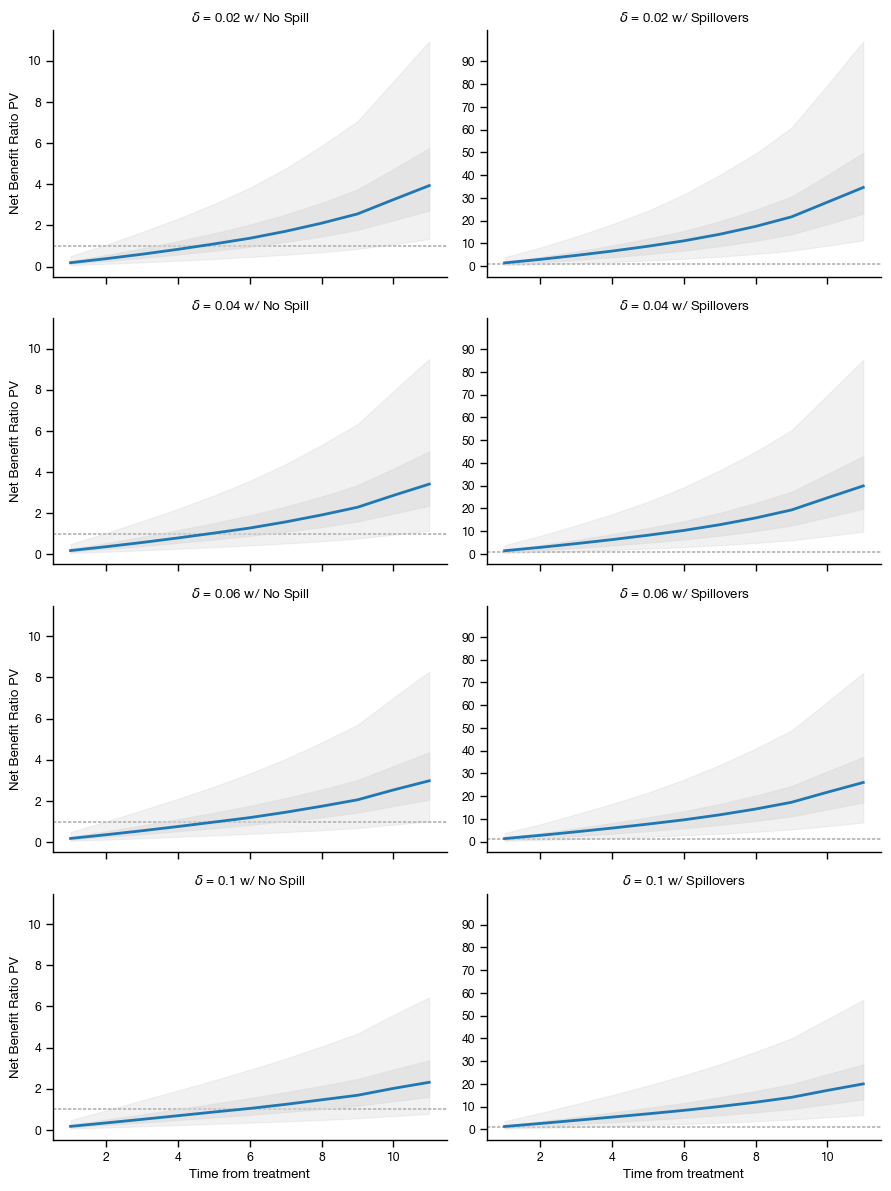

In [365]:
benefits_spill = pd.concat(bens_spill)
benefits = pd.concat([benefits_no_spill, benefits_spill])

# remove weird ratios
benefits = benefits.dropna()

# Select only the discount rates we want to plot
deltas = [0.02, 0.04, 0.06, 0.1]
benefits = benefits[benefits.discount_rate.isin(deltas)]

mean_benefits = (
    benefits.groupby(["lag", "discount_rate", "treatment", "n_treats"])
    .ratio.median()
    .reset_index()
)

g = sns.relplot(
    data=mean_benefits[mean_benefits.n_treats.isin([4000, 1000])],
    x="lag",
    y="ratio",
    row="discount_rate",
    col="treatment",
    kind="line",
    height=3,
    aspect=1.5,
    linewidth=2,
    zorder=5,
    legend=False,
    facet_kws={"sharey": "col", "sharex": True},
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$ = {row_name} w/ {col_name}")
    .tight_layout(w_pad=0)
)


# Plot the 0.25 and 0.975 quantiles for each discount rate and lag
iqr = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
ci = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.05, 0.95])
    .unstack()
    .reset_index()
)

stds = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.std(ddof=2)
    .reset_index()
)

ci_alt = pd.DataFrame(
    {
        "ci_low": mean_benefits.ratio - 1.96 * stds.ratio / np.sqrt(988),
        "ci_high": mean_benefits.ratio + 1.96 * stds.ratio / np.sqrt(988),
        "lag": mean_benefits.lag,
        "discount_rate": mean_benefits.discount_rate,
        "treatment": mean_benefits.treatment,
    }
)

for idxs, ax in g.axes_dict.items():
    dr, treat = idxs
    # Get the quantiles
    q_dr = ci[(ci.discount_rate == dr) & (ci.treatment == treat)]
    q_dr_iqr = iqr[(iqr.discount_rate == dr) & (iqr.treatment == treat)]

    ax.fill_between(
        q_dr.lag,
        q_dr[0.05],
        q_dr[0.95],
        color="#bdbdbd",
        alpha=0.2,
    )

    ax.fill_between(
        q_dr.lag,
        q_dr_iqr[0.25],
        q_dr_iqr[0.75],
        color="#d9d9d9",
        alpha=0.5,
    )

    if treat == "Spillovers":
        ax.set_yticks(np.arange(0, 100, 10))
        ax.set_yticklabels(np.arange(0, 100, 10))


plt.tight_layout()


## Back-on-the-envelope smoke $PM_{2.5}$ benefits

The dataframes we will create here will be used for the plots following this cell. We need to basically execute two main tasks: 
1. Aggregate smoke PM data using the observed severity in our dataset and using the mapping from the `make_model` functions using the same linked data we have used in the past. 
2. We want to aggregate our simulations so they reflect changes in PM at the state level.

In [11]:
# Load smoke link data
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked_new_inmediate.feather"
)

# For each fire select the best coverage threshold!
smoke_linked = smoke_linked.loc[
    smoke_linked.groupby("event_id")["coverage_threshold"].idxmax()
]

# Calculate PM2.5 benefits of cummulative treatments
dnbr_clean = pd.read_parquet("../data/dnbr.parquet")
sum_all_fires = (
    dnbr_clean[dnbr_clean.year >= 2010]
    .groupby(["year"], as_index=False)
    .agg({"dnbr": ["sum", "mean"]})
)
sum_all_fires.columns = ["year", "sum_dnbr", "mean_dnbr"]

preds_pm_all_fires = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
).coef()["sum_severity"]

sum_all_fires["smoke_pm"] = preds_pm_all_fires * sum_all_fires.sum_dnbr
sum_all_fires.to_csv("../data/smoke_pm_all_fires.csv", index=False)

# Estimate parameters again for testing. We later use these for back-on-the-envelope testing
make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
).summary()

###

Estimation:  OLS
Dep. var.: sum_contrib, Fixed effects: year
Inference:  CRV1
Observations:  475

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |     2.5% |    97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|---------:|---------:|
| sum_severity  |      1.554 |        0.492 |     3.161 |      0.007 |    0.500 |    2.609 |
| total_pixels  |    100.034 |      100.448 |     0.996 |      0.336 | -115.405 |  315.473 |
| total_days    |   5208.383 |     1270.722 |     4.099 |      0.001 | 2482.955 | 7933.812 |
---
RMSE: 100973.467 R2: 0.836 R2 Within: 0.818 


### Diagnostic plot: Spillover gains vs. main treatment gains

/tmp/ipykernel_3500457/1506961058.py:23: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(


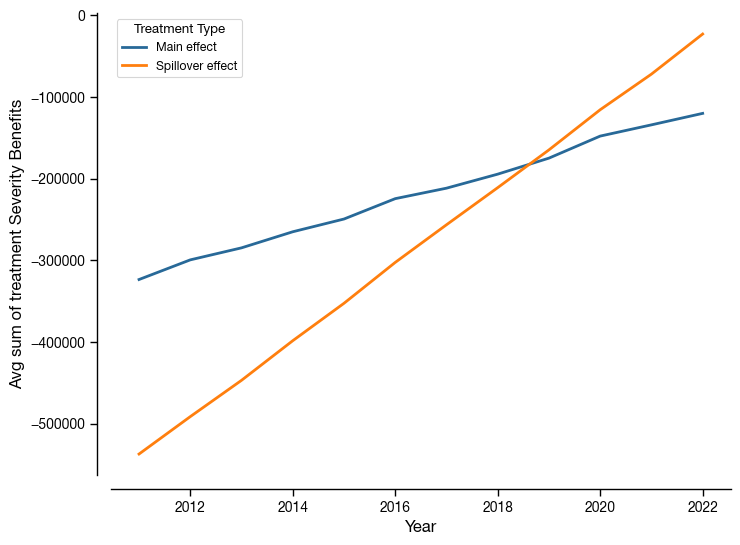

In [12]:
test_spill = duckdb.query(
    """
            SELECT year, 
            case when land_type == 100 then 'Spillover effect'
                 when land_type == 2 then 'Main effect'
                 else 'Other'
                 end as land_type, 
            mean(total_coeff) as avg_coeff
            from (
            SELECT year, year_treat, land_type, sim, COUNT(*) as n_obs, sum(coeff) as total_coeff
            FROM read_parquet('/mnt/sherlock/oak/prescribed_data/results/simulations/policy_spill_large_new_new_2000/*.parquet')
            where year_treat == 2010 and sim == 101
            GROUP BY year, year_treat, land_type, sim 
            ORDER BY year, year_treat, land_type, sim
            )
            GROUP BY year, land_type
            ORDER BY year, land_type
"""
).to_df()


fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=test_spill,
    x="year",
    y="avg_coeff",
    hue="land_type",
    linewidth=2,
    palette=["#286998", "#ff7f0e", "#2ca02c"],
    ax=ax,
)

# Change x and y labels
template_plots(
    ax,
    xlab="Year",
    ylab="Avg sum of treatment Severity Benefits",
)

# Change legend title
ax.legend(title="Treatment Type", loc="upper left")

# Save as a PDF
plt.savefig(
    "../figs/spillover_effects_severity.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


### Diagnostic plot: Spillover gains across treatment years

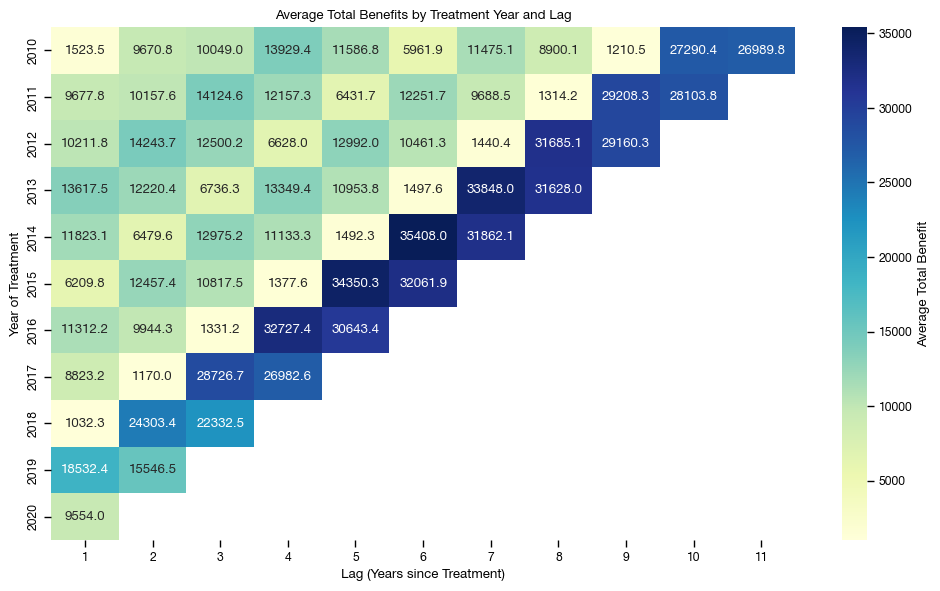

In [13]:
df_spillovers = duckdb.query(
    """
WITH sims AS (
            SELECT 
            grid_id, 
            year,
            year_treat,
            case when 
            coeff > 0 then 0 else coeff 
            end as coeff,
            sim,
            FROM read_parquet('/mnt/sherlock/oak/prescribed_data/results/simulations/policy_spill_large_new_new_2000/*.parquet')
            where land_type == 100
        ), dnbr_data AS (
            SELECT 
                grid_id, 
                year,
                Event_ID   AS event_id,
                dnbr
            FROM '../data/dnbr.parquet'
            WHERE year > 2010
        ), 
        sims_dnbr AS (
            SELECT 
                s.*,
                d.dnbr
            FROM sims s
            INNER JOIN dnbr_data d
            ON s.grid_id = d.grid_id AND s.year = d.year
        ),
        agg_benefits as (
        select 
        year_treat,
        year,
        sum(coeff) as total_coeff,
        COUNT(DISTINCT grid_id) as n_grids,
        sim
        from sims_dnbr
        GROUP BY year_treat, year, sim
        )
        select
        year_treat,
        year,
        year - year_treat as lag,
        sim,
        total_coeff * -1 as total_benefit,
        n_grids,
        from agg_benefits
"""
).to_df()

# Create a heatmap of the total benefits by year_treat and lag
pivot_table = df_spillovers.pivot_table(
    values="total_benefit",
    index="year_treat",
    columns="lag",
    aggfunc="mean",
)
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Average Total Benefit"},
)
plt.title("Average Total Benefits by Treatment Year and Lag")
plt.xlabel("Lag (Years since Treatment)")
plt.ylabel("Year of Treatment")
plt.tight_layout()

# Save plot to PDF
plt.savefig(
    "../figs/heatmap_total_benefits_spillover_effect.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [14]:
sim_files = [
    "policy_no_spill_large_new_4000",
    "policy_spill_large_new_new_500",
    "policy_spill_large_new_new_1000",
    "policy_spill_large_new_new_1500",
    "policy_spill_large_new_new_2000",
]
sizes = [4000, 500, 1000, 1500, 2000]

list_year_benefits = []
for sim_file, size in zip(sim_files, sizes):
    df_year_treat = duckdb.query(
        f"""
        WITH sims AS (
            SELECT 
            grid_id, 
            year,
            year_treat,
            case when 
            coeff > 0 then 0 else coeff 
            end as coeff,
            sim,
            FROM read_parquet('/mnt/sherlock/oak/prescribed_data/results/simulations/{sim_file}/*.parquet')
        ), dnbr_data AS (
            SELECT 
                grid_id, 
                year,
                Event_ID   AS event_id,
                dnbr
            FROM '../data/dnbr.parquet'
            WHERE year > 2010
        ), 
        sims_dnbr AS (
            SELECT 
                s.*,
                d.dnbr
            FROM sims s
            INNER JOIN dnbr_data d
            ON s.grid_id = d.grid_id AND s.year = d.year
        ),
        agg_benefits as (
        select 
        year_treat,
        year,
        sum(coeff) as total_coeff,
        COUNT(DISTINCT grid_id) as n_grids,
        sim
        from sims_dnbr
        GROUP BY year_treat, year, sim
        )
        select
        year_treat,
        year,
        year - year_treat as lag,
        sim,
        total_coeff * -1 as total_benefit,
        n_grids,
        from agg_benefits
        """
    ).to_df()

    # Add the costs
    costs = pd.DataFrame(
        {
            "sim": np.arange(1, 1001),
            "cost_severity": np.random.randint(10, 40, 1_000) * size,
            "f_pm": np.random.normal(1.554, 0.492, 1_000),
            "policy_size": size,
        }
    )

    # Merge costs
    df_year_treat_obs = df_year_treat.merge(costs, on="sim")
    list_year_benefits.append(df_year_treat_obs)

# Combine all year benefits and add the treatment type indicator
year_benefits = pd.concat(list_year_benefits)
year_benefits["treatment"] = np.where(
    year_benefits.policy_size == 4000, "No Spill", "Spillovers"
)

### Diagnostic plot: Heatmap (matrix) as described in the supplement equation 17

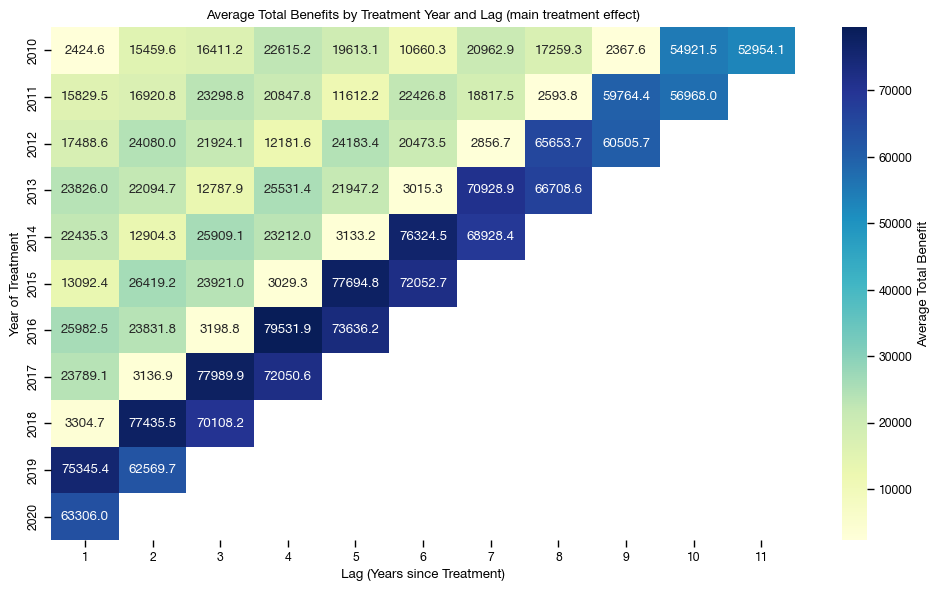

In [ ]:
# Create a heatmap of the total benefits by year_treat and lag
pivot_table = year_benefits[year_benefits.policy_size == 2000].pivot_table(
    values="total_benefit",
    index="year_treat",
    columns="lag",
    aggfunc="mean",
)
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Average Total Benefit"},
)
plt.title(
    "Average Total Benefits by Treatment Year and Lag (main treatment effect)"
)
plt.xlabel("Lag (Years since Treatment)")
plt.ylabel("Year of Treatment")
plt.tight_layout()

# Save plot to PDF
plt.savefig(
    "../figs/heatmap_total_benefits_main_effect.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

### Diagnostic plot: Benefit-cost ratios (Fig 4 without uncertainty just from a simpler approach)

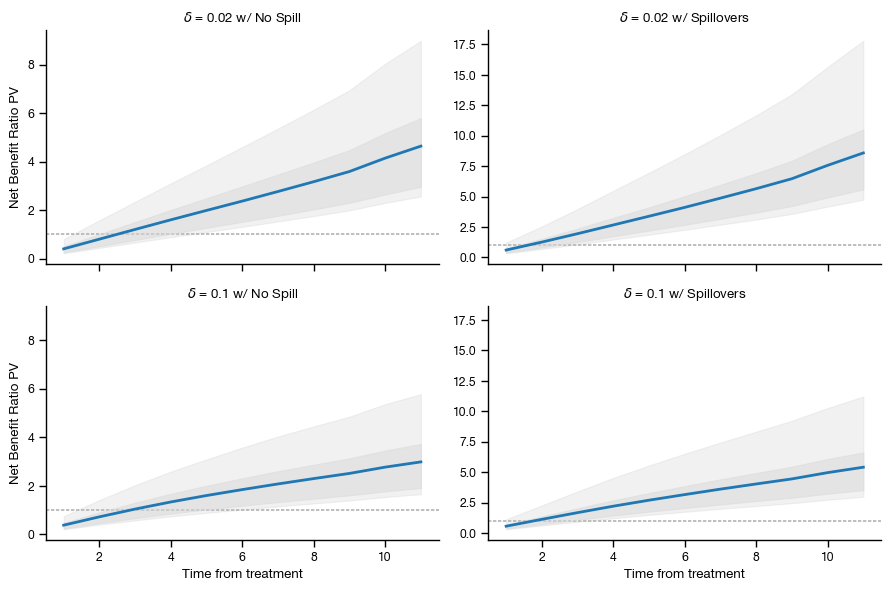

In [16]:
# First, create the xarray from mean_benefits with policy_size as a dimension
# mean_benefits has columns: lag, sim, total_benefit, cost_severity, policy_size
mean_benefits = year_benefits.groupby(
    ["lag", "sim", "policy_size"], as_index=False
)[["total_benefit", "cost_severity", "f_pm"]].mean()

# Pivot to get (lag, sim, policy_size) structure
da = mean_benefits.set_index(["lag", "sim", "policy_size"])[
    ["total_benefit", "cost_severity"]
].to_xarray()

# Get cost (constant across lags, just need one value per sim and policy_size)
cost = da["cost_severity"].isel(lag=0)  # Shape: (sim, policy_size)

# Calculate PV ratios for each discount rate
discount_rates = [0.02, 0.04, 0.06, 0.1]
results = []

for dr in discount_rates:
    discount_factor = 1 / ((1 + dr) ** da.lag)

    # Discounted benefits per period
    discounted_benefits = (
        da["total_benefit"] * discount_factor
    )  # Shape: (lag, sim, policy_size)

    # Cumulative sum along lag dimension (this gives PV up to each lag T)
    cumulative_pv = discounted_benefits.cumsum(
        dim="lag"
    )  # Shape: (lag, sim, policy_size)

    # Ratio: cumulative PV / cost
    ratio = cumulative_pv / cost  # Shape: (lag, sim, policy_size)

    # Convert to dataframe
    ratio_df = ratio.to_dataframe(name="ratio").reset_index()
    ratio_df["discount_rate"] = dr
    results.append(ratio_df)

pv = pd.concat(results, ignore_index=True)

# If policy size is 4000, treatment is No Spill, else Spillovers
pv["treatment"] = np.where(pv.policy_size == 4000, "No Spill", "Spillovers")

# Select only the discount rates we want to plot
deltas = [0.02, 0.1]
benefits = pv[pv.discount_rate.isin(deltas)]

mean_benefits = (
    benefits[benefits.policy_size.isin([4_000, 2_000])]
    .groupby(["lag", "discount_rate", "treatment"])
    .ratio.mean()
    .reset_index()
)

# Plot the 0.25 and 0.975 quantiles for each discount rate and lag
iqr = (
    benefits[benefits.policy_size.isin([4_000, 2_000])]
    .groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
ci = (
    benefits[benefits.policy_size.isin([4_000, 2_000])]
    .groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.05, 0.95])
    .unstack()
    .reset_index()
)

g = sns.relplot(
    data=mean_benefits,
    x="lag",
    y="ratio",
    row="discount_rate",
    col="treatment",
    kind="line",
    height=3,
    aspect=1.5,
    linewidth=2,
    zorder=5,
    legend=False,
    facet_kws={"sharey": "col", "sharex": True},
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$ = {row_name} w/ {col_name}")
    .tight_layout(w_pad=0)
)


for idxs, ax in g.axes_dict.items():
    dr, treat = idxs
    # Get the quantiles
    q_dr = ci[(ci.discount_rate == dr) & (ci.treatment == treat)]
    q_dr_iqr = iqr[(iqr.discount_rate == dr) & (iqr.treatment == treat)]

    ax.fill_between(
        q_dr.lag,
        q_dr[0.05],
        q_dr[0.95],
        color="#bdbdbd",
        alpha=0.2,
    )

    ax.fill_between(
        q_dr.lag,
        q_dr_iqr[0.25],
        q_dr_iqr[0.75],
        color="#d9d9d9",
        alpha=0.5,
    )


plt.tight_layout()

# Save plot
plt.savefig(
    "../figs/pv_benefits_avg.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
plt.show()


## Fig 5: Large-scale prescribed burning reduces future burned area and wildfire smoke $PM_{2.5}$ (Panel C)

In [50]:
sim_files = [
    "policy_no_spill_large_new_4000",
    "policy_spill_large_new_new_500",
    "policy_spill_large_new_new_1000",
    "policy_spill_large_new_new_1500",
    "policy_spill_large_new_new_2000",
]
sizes = [4000, 500, 1000, 1500, 2000]

severity_sim = []
for sim_file, size in zip(sim_files, sizes):
    df = duckdb.query(
        f"""
    WITH sims AS (
        SELECT 
        grid_id, 
        year,
        case when 
        coeff > 0 then 0 else coeff 
        end as coeff,
        sim
        FROM read_parquet('/mnt/sherlock/oak/prescribed_data/results/simulations/{sim_file}/*.parquet')
    ),
    sim_ids AS (
        SELECT DISTINCT sim FROM sims
    ),
    dnbr_data AS (
        SELECT 
            grid_id, 
            year,
            Event_ID   AS event_id, 
            dnbr
        FROM '../data/dnbr.parquet'
        WHERE year > 2010
    ), 
    data_join as (
    SELECT o.*, s.coeff AS effect, s.sim
    FROM dnbr_data o
    INNER JOIN sims s
        ON  o.grid_id = s.grid_id
        AND o.year    = s.year
    ), 
    agg_sim as (
        SELECT 
            year,
            sim,
            SUM(effect) as sum_effect
        FROM data_join
        GROUP BY year, sim
    ), 
    year_obs_agg as (
        select year, unnest(sim_ids_array) as sim, total_obs_dnbr from (
        SELECT 
            year,
            (select array_agg(sim order by sim) from sim_ids) as sim_ids_array,
            SUM(dnbr) as total_obs_dnbr
        FROM dnbr_data
        GROUP BY year
        )
    ) select o.year,
    o.sim, 
    s.sum_effect, 
    o.total_obs_dnbr as obs_dnbr,
    coalesce(o.total_obs_dnbr + s.sum_effect, o.total_obs_dnbr) as sim_dnbr
    from year_obs_agg o
    left join agg_sim s
        on o.year = s.year and o.sim = s.sim
    """
    ).to_df()

    # Add cost of treatment in 2010
    cost_2010 = pd.DataFrame(
        {
            "sim": np.arange(1, 1001),
            "sum_effect": 0,
            "year": 2010,
            "obs_dnbr": 78704.31,
            "sim_dnbr": 78704.31,
        }
    )

    df = pd.concat([df, cost_2010])
    df["policy_size"] = size

    severity_sim.append(df)

df = pd.concat(severity_sim)

### Diagnostic plot: Total severity reduction over time with different treatment sizes (without cost!)

<Axes: xlabel='year', ylabel='sim_dnbr'>

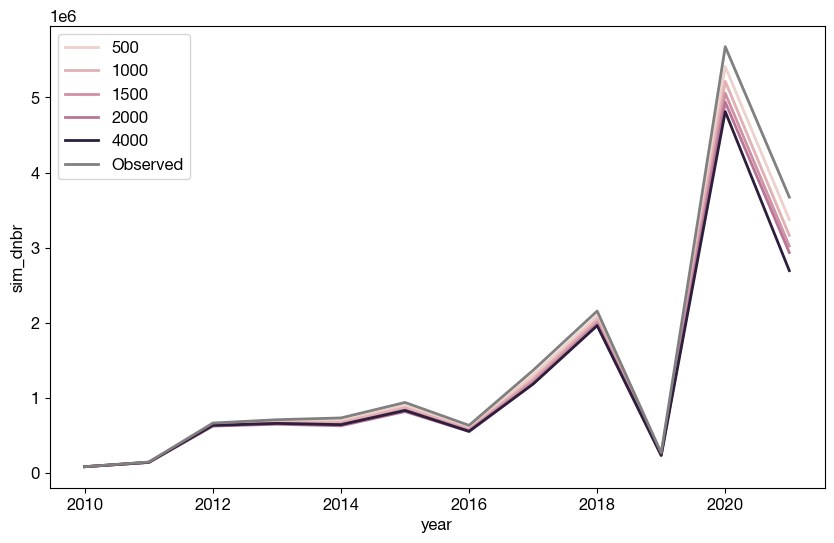

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=df.groupby(["year", "policy_size"], as_index=False).sim_dnbr.min(),
    x="year",
    y="sim_dnbr",
    linewidth=2,
    hue="policy_size",
    ax=ax,
)

sns.lineplot(
    data=df.groupby(["year", "policy_size"], as_index=False).obs_dnbr.mean(),
    x="year",
    linewidth=2,
    y="obs_dnbr",
    color="gray",
    label="Observed",
    ax=ax,
)

In [52]:
agg_sim_savings = []
for size in sizes:
    # Calculate PM costs
    pm = pd.DataFrame(
        {
            "sim": np.arange(1, 1001),
            "f_pm": np.random.normal(1.554, 0.492, 1_000),
            "cost_severity": np.random.randint(0, 40, 1_000),
        }
    )
    pm = pm.assign(**{"cost": pm.cost_severity * size})

    # Merge with savings data from simulations
    sim_test_agg = df[df.policy_size == size].merge(pm, on="sim", how="left")
    sim_test_agg.sort_values(by=["sim", "year"], inplace=True)
    # sim_test_agg = sim_test_agg[sim_test_agg.year > 2011]

    # Calculate smoke PM for observed and simulated
    sim_test_agg["obs_pm"] = sim_test_agg.obs_dnbr
    sim_test_agg["sim_pm"] = sim_test_agg.sim_dnbr + sim_test_agg.cost
    sim_test_agg["savings_raw"] = sim_test_agg.sim_pm - sim_test_agg.obs_pm

    # Calculate the savings
    sim_test_agg["savings_pm"] = (
        sim_test_agg.sim_pm - sim_test_agg.obs_pm
    ) / sim_test_agg.obs_pm

    sim_test_agg["cum_savings_pm"] = (
        sim_test_agg.groupby(["sim"])
        .apply(lambda x: (x.sim_pm - x.obs_pm).cumsum() / x.obs_pm.cumsum())
        .reset_index(level=0, drop=True)
    )

    agg_sim_savings.append(sim_test_agg)

agg_sim_savings = pd.concat(agg_sim_savings)

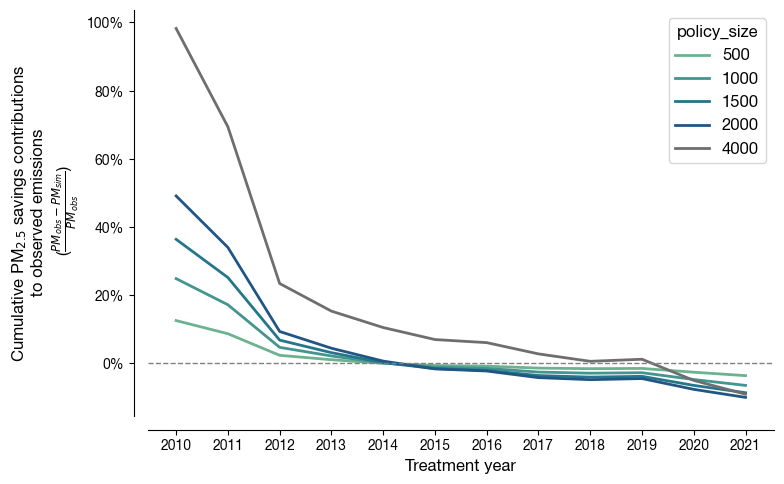

In [53]:
from matplotlib.ticker import PercentFormatter

# Make it match with other colors for spillovers size
palette_dict = {
    4000: "#6e6e6f",
    500: sns.color_palette(palette="crest", n_colors=4)[0],
    1000: sns.color_palette(palette="crest", n_colors=4)[1],
    1500: sns.color_palette(palette="crest", n_colors=4)[2],
    2000: sns.color_palette(palette="crest", n_colors=4)[3],
}

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(
    data=agg_sim_savings,
    x="year",
    y="cum_savings_pm",
    hue="policy_size",
    palette=palette_dict,
    linewidth=2,
    err_style=None,
    # errorbar=("pi", 0),
    ax=ax,
)

# Add all years to the x-axis
ax.set_xticks(np.arange(2010, 2022, 1))
ax.set_xticklabels(np.arange(2010, 2022, 1), rotation=45)

template_plots(
    ax,
    xlab="Treatment year",
    ylab="Cumulative PM$_{2.5}$ savings contributions \n to observed emissions \n ($\\frac{PM_{obs}- PM_{sim}}{PM_{obs}}$)",
)

# ax.set_ylim(-0.1, 110)

# Add a horizontal line at 0.1
ax.axhline(
    y=0, color="gray", linestyle="--", linewidth=1, label="100% threshold"
)
# Format y-axis as percentages (multiply by 100)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# Change range of plot from -0.1 to 1.5
# ax.set_ylim(0.9, 1.5)
plt.tight_layout()


# Save the plot as a PDF
plt.savefig(
    "../figs/benefits_share_pm_ratio.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

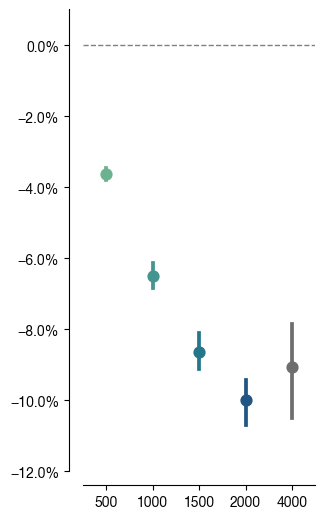

In [85]:
new_data = agg_sim_savings[agg_sim_savings.year == 2021]
fig, ax = plt.subplots(figsize=(3, 6))
sns.pointplot(
    data=new_data,
    x="policy_size",
    y="cum_savings_pm",
    color="black",
    linestyle="none",
    hue="policy_size",
    palette=palette_dict,
    # err_style="bars",
    legend=False,
    errorbar=("pi", 25),
    ax=ax,
)

# Format y-axis as percentages (multiply by 100)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=1))

# Add a horizontal line at 0%
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1, label="0% threshold")
template_plots(ax, xlab="", ylab="")

# Set the y-axis limits
ax.set_ylim(-0.12, 0.01)


# Save the plot as a PDF
plt.savefig(
    "../figs/benefits_share_pm_ratio_2020_ci.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)


In [83]:
new_data.groupby(["policy_size"])["cum_savings_pm"].describe(percentiles=[0.025, 0.5, 0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
policy_size,,,,,,,,
500,1000.0,-0.036246,0.004072,-0.044457,-0.043338,-0.036301,-0.029430,-0.027832
1000,1000.0,-0.064898,0.008283,-0.080061,-0.078620,-0.065006,-0.051461,-0.049516
1500,1000.0,-0.086372,0.012071,-0.107507,-0.106060,-0.086516,-0.066176,-0.063221
2000,1000.0,-0.100032,0.016145,-0.128722,-0.126280,-0.100872,-0.072996,-0.071642
4000,1000.0,-0.090717,0.032314,-0.146888,-0.142906,-0.090108,-0.037189,-0.032608


## Fig S18: State $PM_{2.5}$ under different policies

In [169]:
# Discounting and other parameters
policies = [4000, 500, 1000, 1500, 2000]
perc_ca = 0.88
cost_per_acre = 600

# Calculate VSL in 2010 dollars
vsl = 7_400_000
cpi_2006 = 201.6
cpi_2010 = 218.056
inflation_factor = cpi_2010 / cpi_2006
vsl_adjusted = vsl * inflation_factor

# Calculate discounting
discount = 0.02

# Calculate cost per treatment
cost_rx = pd.DataFrame(
    {
        "policy_size": policies,
        "cost_per_treatment": [size * cost_per_acre for size in policies],
    }
)

# Load mortality data and aggregate at the county level for CA
mortality = pd.read_parquet("../data/ca_counties_annual_total_pop.pq")

mortality_ca = mortality[
    (mortality["year"] >= 2010)
    & (mortality["fips"].str.startswith("06"))
    & (mortality["year"] <= 2021)
]

mortality_ca = mortality_ca.groupby(["fips", "year"], as_index=False).agg(
    {"pop": "mean"}
)

mortality_ca["fips"] = mortality_ca["fips"].astype(int)

# Read in the county-level PM2.5 data from Childs et al. 2022 and aggregate to annual/county
pm_county = pd.read_csv(
    "../data/smokePM2pt5_predictions_daily_county_20060101-20231231.csv"
)
pm_county["date"] = pd.to_datetime(pm_county["date"], format="%Y%m%d")

pm_county = pm_county[
    (pm_county["GEOID"].astype(str).str.startswith("6"))
    & (pm_county["date"].dt.year >= 2010)
]

# Aggregate to annual average per county
pm_county = (
    pm_county.groupby(["GEOID", pm_county["date"].dt.year])["smokePM_pred"]
    .apply(lambda x: x.sum() / 365)
    .reset_index()
)

# Add population data
pm_county = pm_county.merge(
    mortality_ca,
    left_on=["GEOID", "date"],
    right_on=["fips", "year"],
    how="right",
)

# Aggregate to all the years with population-weighted average
pm_county = (
    pm_county.groupby("date", as_index=False)
    .apply(lambda g: np.average(g["smokePM_pred"], weights=g["pop"]))
    .rename(columns={None: "smokePM_pred"})
)

# Expand dataframe to have the pm_county repeated per each policy size
pm_county_policy = pd.concat(
    [pm_county.assign(policy_size=size) for size in policies],
    ignore_index=True,
)

# Get the average simulated savings in PM per policy size and year
avg_savings = agg_sim_savings.groupby(
    ["year", "policy_size"], as_index=False
).agg(savings_pm=("savings_pm", "mean"), savings_raw=("savings_raw", "mean"))

# Re-format the savings to simplify the calculation 
avg_savings["savings_pm_factor"] = 1 + (avg_savings.savings_pm * perc_ca)

# Merge the average savings with the county-level PM data
pm_county_policy = pm_county_policy.merge(
    avg_savings[
        [
            "year",
            "policy_size",
            "savings_pm_factor",
            "savings_pm",
            "savings_raw",
        ]
    ],
    left_on=["date", "policy_size"],
    right_on=["year", "policy_size"],
    how="left",
)

pm_county_policy["pm_change"] = (
    pm_county_policy.smokePM_pred * pm_county_policy.savings_pm_factor
)


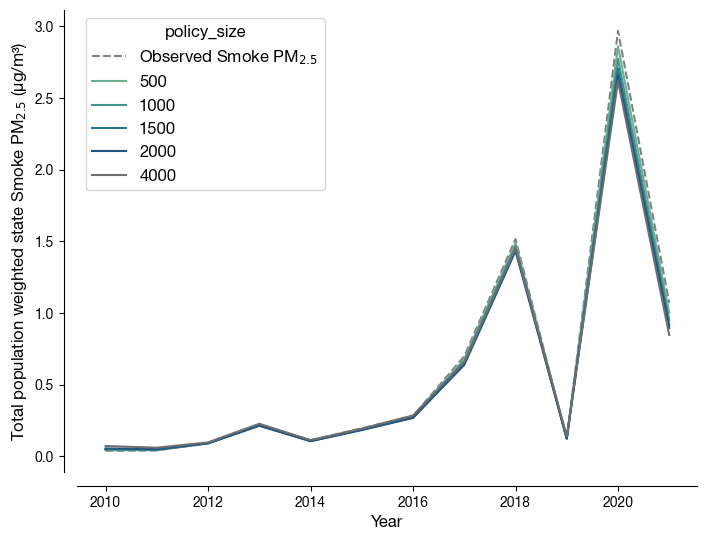

In [170]:
fig, ax = plt.subplots(figsize=(8, 6))

pm_county_policy["raw_savings_pm"] = (
    pm_county_policy.smokePM_pred - pm_county_policy.pm_change
)

# Add the observed PM line
sns.lineplot(
    data=pm_county_policy.groupby("date", as_index=False)
    .apply(
        lambda g: pd.Series(
            {
                "total_pm": g["smokePM_pred"].mean(),
            }
        )
    )
    .reset_index(),
    x="date",
    y="total_pm",
    color="gray",
    linewidth=1.5,
    linestyle="dashed",
    label="Observed Smoke PM$_{2.5}$",
    ax=ax,
)

sns.lineplot(
    data=pm_county_policy.groupby(["date", "policy_size"], as_index=False)
    .apply(
        lambda g: pd.Series(
            {
                "total_pm": g["smokePM_pred"].mean(),
                "total_pm_policy": g["pm_change"].mean(),
                "total_savings": g["raw_savings_pm"].mean(),
            }
        )
    )
    .reset_index(),
    x="date",
    y="total_pm_policy",
    hue="policy_size",
    linewidth=1.5,
    palette=palette_dict,
    ax=ax,
)

# Add horizontal line at y=0
# ax.axhline(y=0, color="gray", linestyle="--", linewidth=1)

# Add template
template_plots(
    ax,
    xlab="Year",
    ylab="Total population weighted state Smoke PM$_{2.5}$ (µg/m³)",
)

# Save the plot as a PDF
plt.savefig(
    "../figs/total_smoke_pm_ca_policy_sizes.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

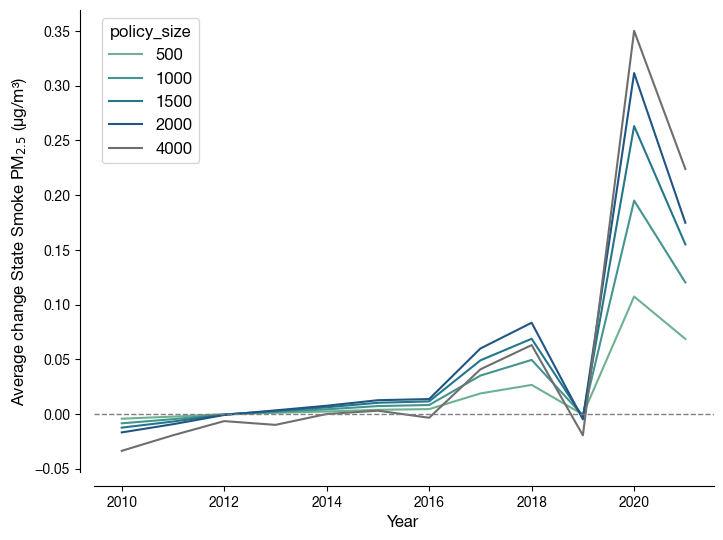

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))

pm_county_policy["raw_savings_pm"] = (
    pm_county_policy.smokePM_pred - pm_county_policy.pm_change
)

sns.lineplot(
    data=pm_county_policy.groupby(["date", "policy_size"], as_index=False)
    .apply(
        lambda g: pd.Series(
            {
                "total_pm": g["smokePM_pred"].mean(),
                "total_pm_policy": g["pm_change"].mean(),
                "total_savings": g["raw_savings_pm"].mean(),
            }
        )
    )
    .reset_index(),
    x="date",
    y="total_savings",
    hue="policy_size",
    linewidth=1.5,
    palette=palette_dict,
    ax=ax,
)

# Add horizontal line at y=0
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1)

# Add template
template_plots(
    ax,
    xlab="Year",
    ylab="Average change State Smoke PM$_{2.5}$ (µg/m³)",
)

# Save the plot as a PDF
plt.savefig(
    "../figs/avg_smoke_pm_ca_policy_sizes.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

In [14]:
pm_county_policy.groupby(["date", "policy_size"], as_index=False).apply(
    lambda g: pd.Series(
        {
            "total_pm": g["smokePM_pred"].mean(),
            "total_pm_policy": g["pm_change"].mean(),
            "total_savings": g["raw_savings_pm"].mean(),
        }
    )
).reset_index().total_savings.groupby(pm_county_policy.policy_size).mean()

policy_size
500     0.000971
1000    0.007525
1500    0.039297
2000    0.162150
4000   -0.009923
Name: total_savings, dtype: float64

## Fig S14: Emissions Net Benefit ratios by spillover treatments 

In [14]:
# remove weird ratios
benefits = benefits.dropna()

# Select only the discount rates we want to plot
deltas = [0.02]
benefits = benefits[benefits.discount_rate.isin(deltas)]

mean_benefits = (
    benefits.groupby(["lag", "discount_rate", "treatment", "n_treats"])
    .ratio.median()
    .reset_index()
)

g = sns.relplot(
    data=mean_benefits[mean_benefits.treatment.isin(["Spillovers"])],
    x="lag",
    y="ratio",
    row="discount_rate",
    col="n_treats",
    kind="line",
    hue="n_treats",
    height=4,
    aspect=1,
    linewidth=2,
    zorder=5,
    palette="crest",
    legend=False,
    facet_kws={
        "sharey": "row",
        "sharex": True,
    },
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$ = {row_name} w/ {col_name}")
    .tight_layout(w_pad=0)
)


# Plot the 0.25 and 0.975 quantiles for each discount rate and lag
iqr = (
    benefits.groupby(["lag", "discount_rate", "n_treats"])
    .ratio.quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
ci = (
    benefits.groupby(["lag", "discount_rate", "n_treats"])
    .ratio.quantile([0.05, 0.95])
    .unstack()
    .reset_index()
)

stds = (
    benefits.groupby(["lag", "discount_rate", "n_treats"])
    .ratio.std(ddof=2)
    .reset_index()
)

ci_alt = pd.DataFrame(
    {
        "ci_low": mean_benefits.ratio - 1.96 * stds.ratio / np.sqrt(988),
        "ci_high": mean_benefits.ratio + 1.96 * stds.ratio / np.sqrt(988),
        "lag": mean_benefits.lag,
        "discount_rate": mean_benefits.discount_rate,
        "treatment": mean_benefits.n_treats,
    }
)

for idxs, ax in g.axes_dict.items():
    dr, n_treats = idxs
    # Get the quantiles
    q_dr = ci[(ci.discount_rate == dr) & (ci.n_treats == n_treats)]
    q_dr_iqr = iqr[(iqr.discount_rate == dr) & (iqr.n_treats == n_treats)]

    ax.fill_between(
        q_dr.lag,
        q_dr[0.05],
        q_dr[0.95],
        color="#bdbdbd",
        alpha=0.2,
    )

    ax.fill_between(
        q_dr.lag,
        q_dr_iqr[0.25],
        q_dr_iqr[0.75],
        color="#d9d9d9",
        alpha=0.5,
    )
    # plt.yscale("asinh", shift=10)
    # ax.set_yscale("log")


plt.tight_layout()

# # Save plot
# plt.savefig(
#     "../figs/pv_benefits_pe_avg_spill_size.pdf",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )


NameError: name 'benefits' is not defined

## Fig S20: Treatment targeting probability estimation

In [174]:
calfire_rx.TREATED_AC.sum() / 248

1189.9730754262075

In [151]:
# Load FRAP prescribed fire data from Calfire
calfire_rx = gpd.read_file("../data/fire24_1.gdb")
calfire_rx = calfire_rx[
    (~calfire_rx["START_DATE"].isna())
    & (calfire_rx["START_DATE"].dt.year >= 2010)
    & (calfire_rx["START_DATE"].dt.year < 2022)
    & (calfire_rx["TREATMENT_TYPE"] == 1)
]

# Add treatment year as the treat year to then follow each treatment against
# observed data
calfire_rx = calfire_rx.assign(
    treat_year=calfire_rx["START_DATE"].dt.year,
)

# Save the number of treatment to calculate the targeting probability
total_year_rx = calfire_rx.groupby("treat_year", as_index=False).agg(
    total_acres=("TREATED_AC", "sum")
)
total_year_rx["total_km"] = total_year_rx["total_acres"] / 248 # acres to km2

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'fire24_1.gdb': 'rxburn24_1' (default), 'firep24_1'. Specify layer parameter to avoid this warning.
  result = read_func(


In [152]:
total_year_rx

,treat_year,total_acres,total_km
0,2010,16022.552344,64.607066
1,2011,29976.348091,120.872371
2,2012,16889.343128,68.102190
3,2013,12447.454405,50.191348
4,2014,8815.376339,35.545872
5,2015,14966.122174,60.347267
6,2016,5739.882965,23.144689
7,2017,14893.451539,60.054240
8,2018,37433.661721,150.942184
9,2019,73551.630000,296.579153


In [158]:
# Transform dnbr to geopandas to find the treatments that overlap with fires
dnbr_gdf = gpd.GeoDataFrame(
    dnbr,
    geometry=gpd.points_from_xy(dnbr.lon, dnbr.lat),
    crs="EPSG:3310",
)
dnbr_gdf = dnbr_gdf[dnbr_gdf.year >= 2010]
dnbr_gdf = dnbr_gdf.to_crs(calfire_rx.crs)

# Get the number of treatments inside a particular fire event in MTBS
calfire_rx_mtbs = gpd.sjoin(
    dnbr_gdf,
    calfire_rx,
    how="inner",
    predicate="within",
)

# Remove all the matches before the treat year
calfire_rx_mtbs = calfire_rx_mtbs[
    calfire_rx_mtbs.year > calfire_rx_mtbs.treat_year
]

# Aggregate the number of unique grids treated per treatment year and year
# to get the count of times that the fires overlap
calfire_rx_mtbs_agg = calfire_rx_mtbs.groupby(
    ["treat_year", "year"], as_index=False
).agg(size=("grid_id", "nunique"))

# Add the size for each treated year to calculate the share treated
calfire_rx_mtbs_agg = calfire_rx_mtbs_agg.merge(
    total_year_rx,
    on="treat_year",
    how="left",
)

# Calculate the cumulative acres treated per treatment year
calfire_rx_mtbs_agg["cum_treat"] = (
    calfire_rx_mtbs_agg.sort_values(["year", "treat_year"])
    .groupby("treat_year")["size"]
    .cumsum()
)

# Calculate the cumulative acres as a share of total acres
calfire_rx_mtbs_agg["cum_acres_share"] = (
    calfire_rx_mtbs_agg["cum_treat"] / calfire_rx_mtbs_agg["total_km"]
)

calfire_rx_mtbs_agg["cum_acres_share"] = np.where(
    calfire_rx_mtbs_agg["cum_acres_share"] > 1, 1, calfire_rx_mtbs_agg["cum_acres_share"]
)

In [154]:
sim_file = "policy_no_spill_large_new_4000"

df = duckdb.query(
    f"""
WITH sims AS (
        SELECT 
        grid_id, 
        year,
        year_treat,
        case when 
        coeff > 0 then 0 else coeff 
        end as coeff,
        sim
        FROM read_parquet('/mnt/sherlock/oak/prescribed_data/results/simulations/{sim_file}/*.parquet')
    ),
    sim_ids AS (
        SELECT DISTINCT sim FROM sims
    ),
    dnbr_data AS (
        SELECT 
            grid_id, 
            year,
            Event_ID   AS event_id, 
            dnbr
        FROM '../data/dnbr.parquet'
        WHERE year > 2010
    ), 
    data_join as (
    SELECT o.*, 
    s.coeff AS effect, 
    s.sim, 
    s.year_treat
    FROM dnbr_data o
    INNER JOIN sims s
        ON  o.grid_id = s.grid_id
        AND o.year    = s.year
    ),
    count_jackpot as (
    select 
    year, 
    year_treat,
    max(jackpot) as avg_jackpot 
    from (
    select year_treat, year, sim, count(distinct grid_id) as jackpot 
    from data_join 
    group by year_treat, year, sim
    ) group by year, year_treat
    ), count_fire as (
    select year_treat, year, count(distinct grid_id) as total_fire_year 
    from dnbr_data
    group by year, year_treat
    order by 1
    ) select  
    j.year_treat, 
    j.year, 
    j.avg_jackpot, 
    f.total_fire_year,
    from count_jackpot j
    inner join count_fire f
    on j.year = f.year
    """
).to_df()

In [159]:
df["lag"] = df.year - df.year_treat

# Calculate cumulative sum of avg_jackpot by year_treat
df["cum_jackpot"] = (
    df.sort_values(by=["year_treat", "year"])
    .groupby("year_treat")["avg_jackpot"]
    .cumsum()
)

# Calculate cumulative sum of avg_jackpot by year_treat
df["cum_total_fire"] = (
    df.sort_values(by=["year_treat", "year"])
    .groupby("year_treat")["total_fire_year"]
    .cumsum()
)

# Probability of treatment given fire
df["cum_prob"] = df["cum_jackpot"] / 4_000
df["prob"] = df["avg_jackpot"] / df["total_fire_year"]


# Add fire to calfire
calfire_rx_mtbs_obs = calfire_rx_mtbs_agg.merge(
    df.groupby("year")["total_fire_year"].mean(),
    left_on="year",
    right_on="year",
    how="left",
)

calfire_rx_mtbs_obs["lag"] = (
    calfire_rx_mtbs_obs.year - calfire_rx_mtbs_obs.treat_year
)

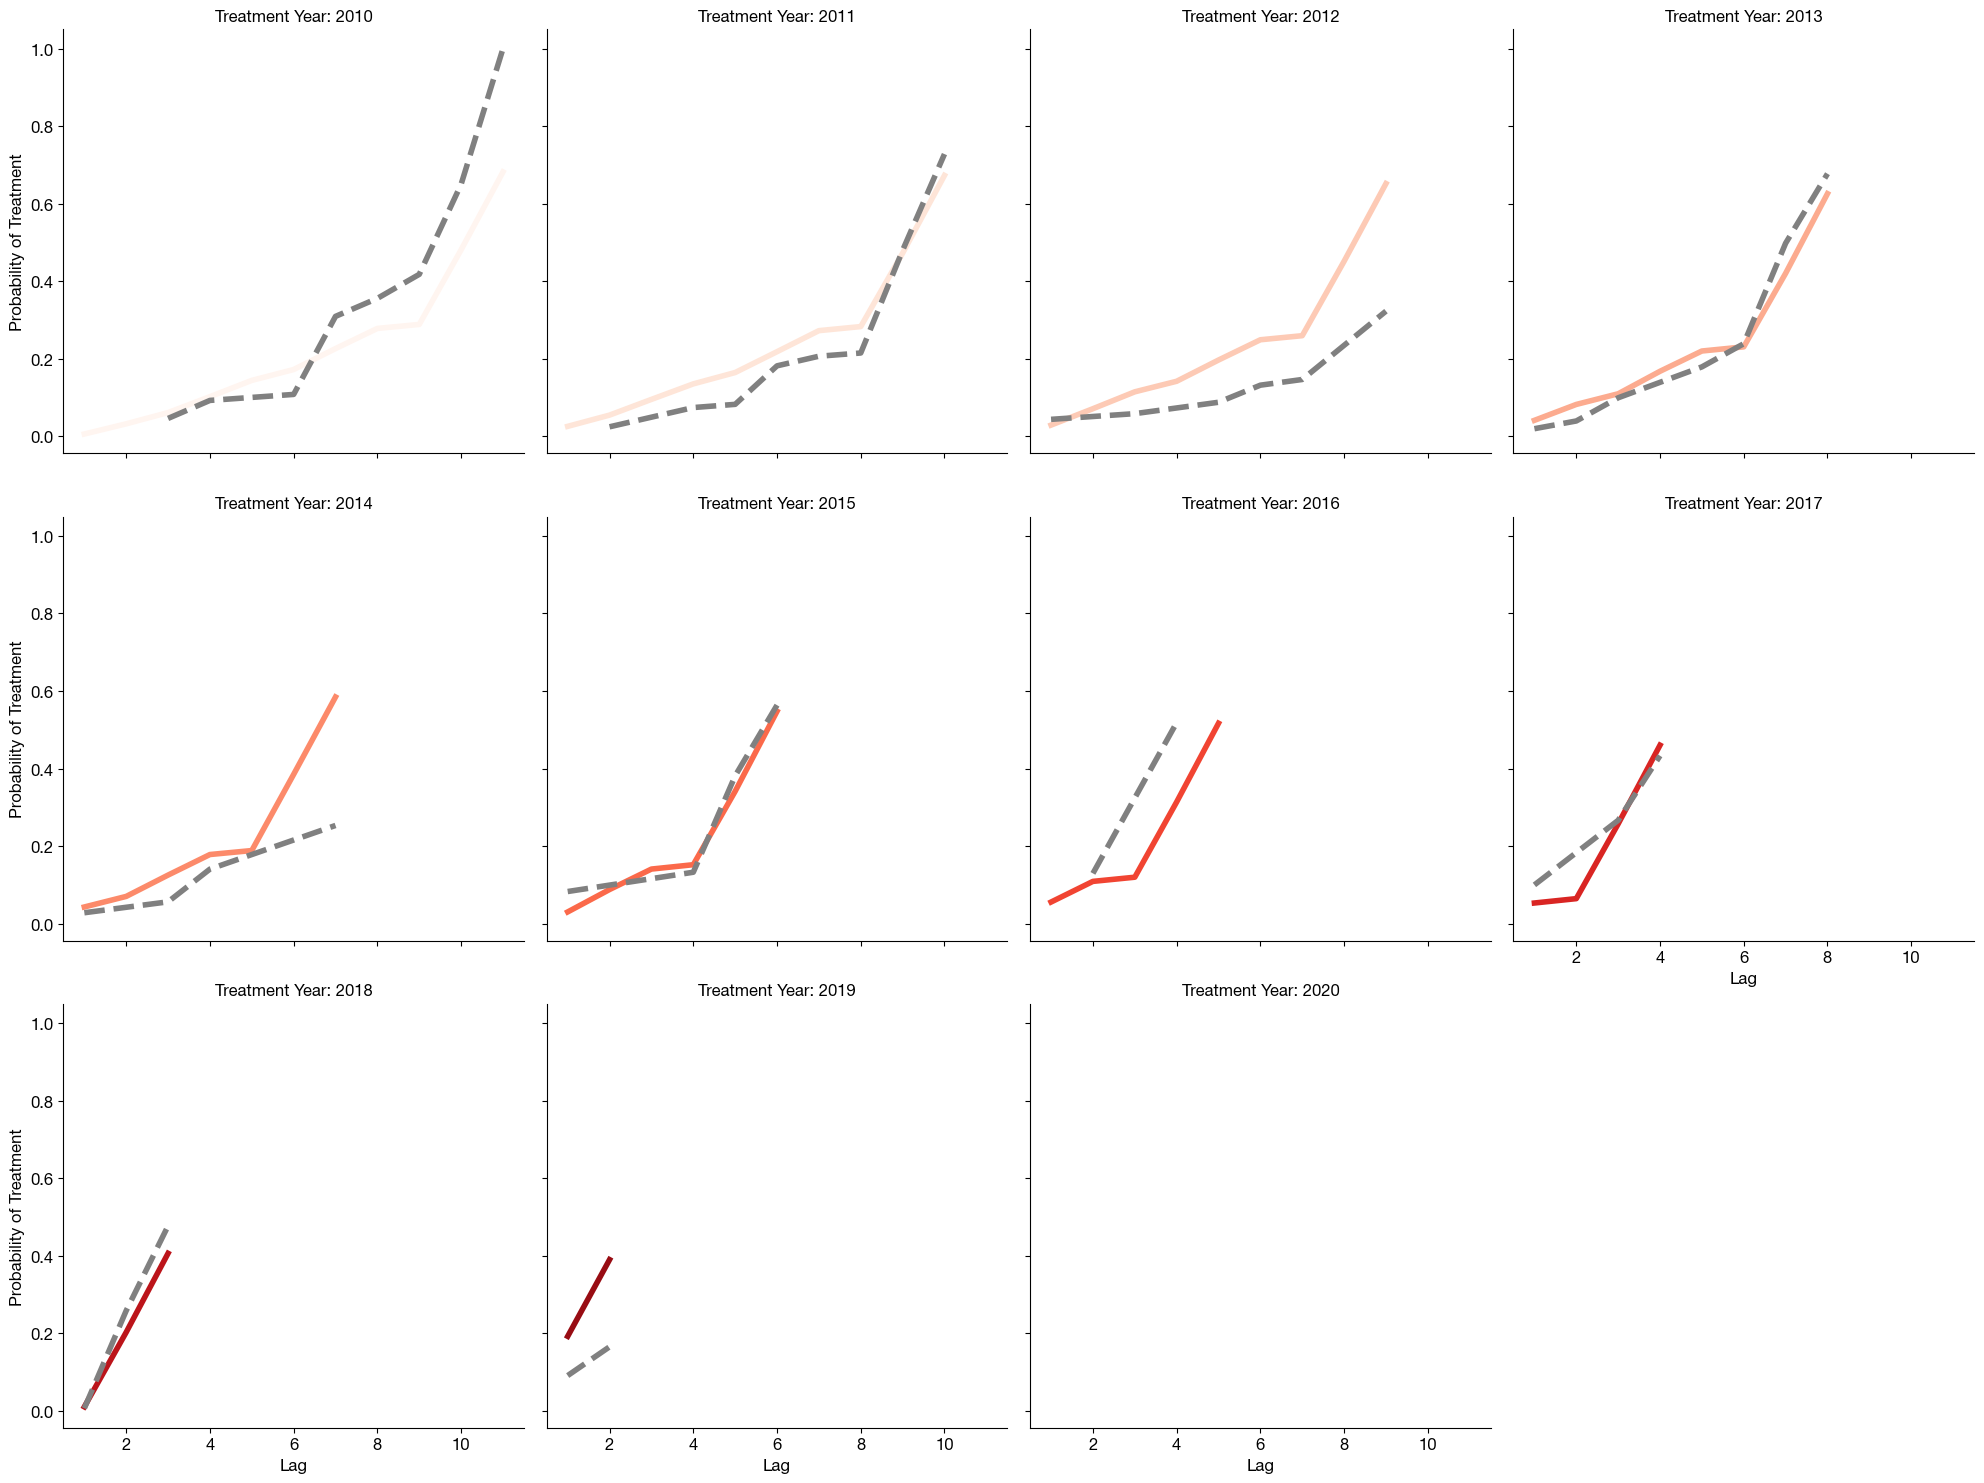

In [160]:
g = sns.relplot(
    data=df,
    x="lag",
    y="cum_prob",
    linewidth=4,
    hue="year_treat",
    col="year_treat",
    palette="Reds",
    kind="line",
    col_wrap=4,
    height=5,
    legend=False,
)


for year, ax in g.axes_dict.items():
    sns.lineplot(
        data=calfire_rx_mtbs_obs[calfire_rx_mtbs_obs.treat_year == year],
        x="lag",
        y="cum_acres_share",
        color="gray",
        linewidth=4,
        linestyle="dashed",
        ax=ax,
    )

g.set_titles("Treatment Year: {col_name}")
g.set_axis_labels("Lag", "Probability of Treatment")
plt.tight_layout()

# Save plot
plt.savefig(
    "../figs/prob_treatment_given_fire.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

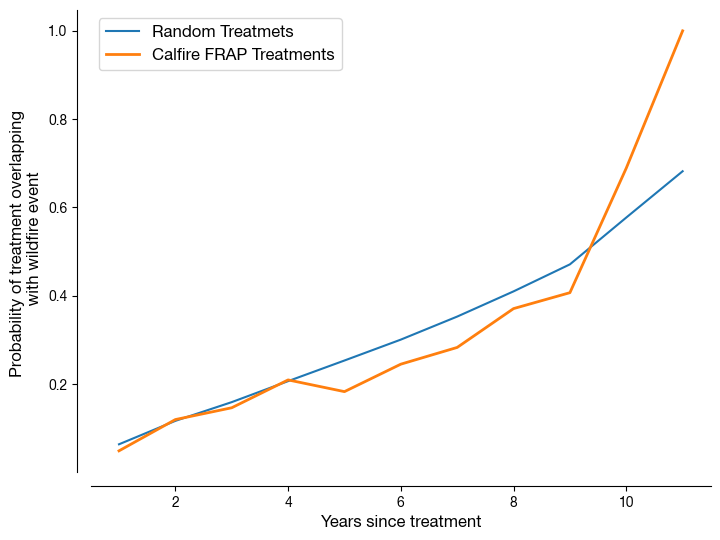

In [161]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=df.groupby(["lag"])
    .agg(avg_prob_fire=("cum_prob", "mean"))
    .reset_index(),
    x="lag",
    y="avg_prob_fire",
    ax=ax,
    label="Random Treatmets",
)

sns.lineplot(
    #data=calfire_rx_mtbs_obs,
    data=calfire_rx_mtbs_obs.groupby("lag")
    .agg(avg_acres_fire=("cum_acres_share", "mean"))
    .reset_index(),
    x="lag",
    y="avg_acres_fire",
    #y="cum_acres_share",
    #color="red",
    #hue="treat_year",
    linewidth=2,
    ax=ax,
    label="Calfire FRAP Treatments",
)

# Apply template
template_plots(
    ax,
    xlab="Years since treatment",
    ylab="Probability of treatment overlapping \n with wildfire event",
)

# Save the plot as a PDF
plt.savefig(
    "../figs/probability_treatment_overlapping_fire.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

## Fig S8: Low-severity treatment simulation (Panel A)

In [45]:
path = f"{sim_path}/policy_no_spill_large_new_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select grid_id, year_treat, event_id, event_name, mean(sim_benefit) as mean_benefit
from benefits_grid_simulation
where event_id == 'CA3720111927220200905' and year
group by grid_id, year_treat, event_id, event_name
""").to_df()

grids_fire = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "lat", "lon"]]

df = df.merge(grids_fire, on="grid_id")

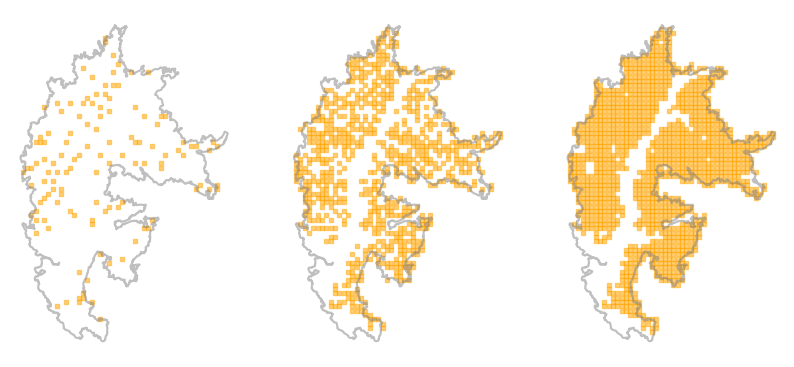

In [46]:
# Total treats
treat_time = df.groupby(
    ["grid_id", "lat", "lon"], as_index=False
).year_treat.first()


years_plot = [2010, 2015, 2020]

# Plot each year in df as scatter
fig, ax = plt.subplots(1, len(years_plot), figsize=(10, 10))

for ax, year in zip(ax.flatten(), years_plot):
    data = treat_time[treat_time.year_treat <= year]
    ax.scatter(data.lon, data.lat, marker=",", s=5, c="orange", alpha=0.5)
    mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
        ax=ax, color="gray", alpha=0.5
    )
    ax.axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/treats_fire_creek.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [47]:
# Count of treated area for plot annotation
(treat_time.groupby("year_treat").grid_id.count().cumsum()) / 1772

year_treat
2010    0.069413
2011    0.139391
2012    0.222348
2013    0.293454
2014    0.365688
2015    0.446953
2016    0.523138
2017    0.586907
2018    0.665350
2019    0.743228
Name: grid_id, dtype: float64

## Fig S8: Low-severity treatment simulation (Panel B)

In [48]:
df_complete = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "dnbr", "lat", "lon"]].merge(
    df, on=["grid_id", "lat", "lon"], how="left"
)
df_complete["mean_benefit"] = df_complete.mean_benefit.fillna(df_complete.dnbr)

df_complete["pixel_benefit"] = df_complete.dnbr - df_complete.mean_benefit

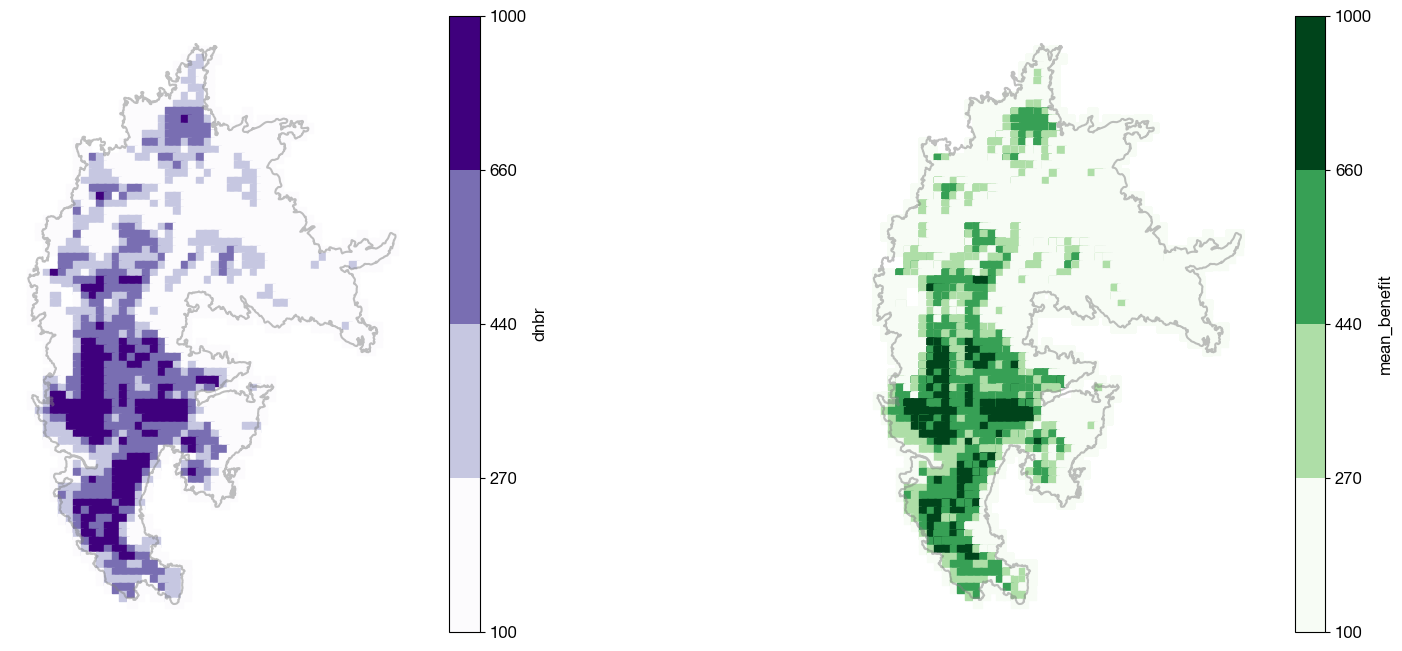

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Unify the colorbar for both plots
vmin = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.min()
vmax = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.max()

df_complete.plot(
    x="lon",
    y="lat",
    kind="scatter",
    c="mean_benefit",
    s=45,
    marker=",",
    ax=ax[1],
    cmap="Greens",
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[1], color="gray", alpha=0.5
)

treatments_dnbr[treatments_dnbr.Event_ID == "CA3720111927220200905"].plot(
    ax=ax[0],
    x="lon",
    y="lat",
    kind="scatter",
    c="dnbr",
    s=50,
    marker=",",
    cmap="Purples",
    colorbar=True,
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[0], color="gray", alpha=0.5
)

ax[0].axis("off")
ax[1].axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/fire_creek_benefit.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## Fig S8: Low-severity treatment simulation (Panel C)

In [9]:
path = f"{sim_path}/policy_no_spill_large_new_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        s.sim,
        s.coeff, 
        d.dnbr,
        d.dnbr + s.coeff as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select *
from benefits_grid_simulation
""").to_df()

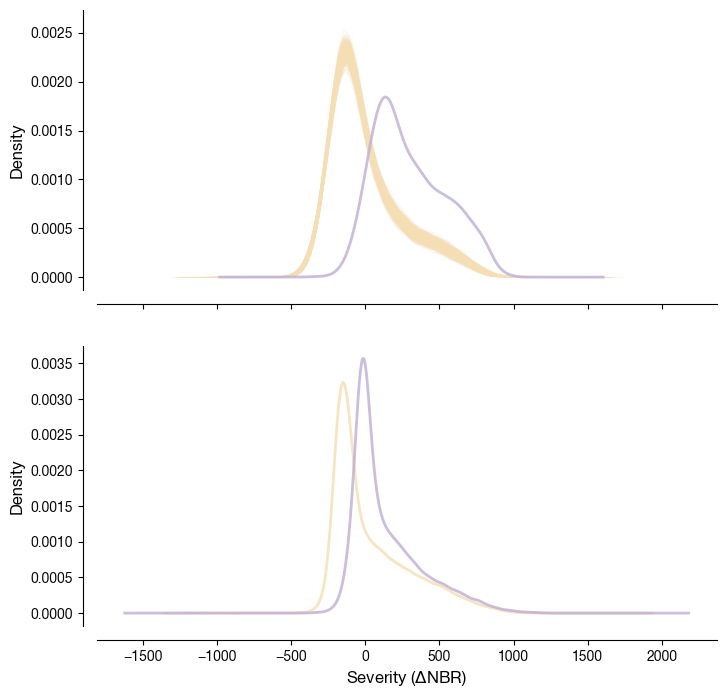

In [ ]:
# Plot distribution of benefits
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

sims_event = df[df.event_id == "CA3720111927220200905"]

for sim in df.sim.unique():
    sims_event[(sims_event.sim == sim)].sim_benefit.plot.density(
        ax=ax[0], color="wheat", alpha=0.5, linewidth=0.1
    )

treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.plot.density(ax=ax[0], color="#beaed4", linewidth=2, alpha=0.8)


# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Plot the same, but for all the events
all_sims = (
    df.groupby(["grid_id"])
    .sim_benefit.median()
    .plot.density(ax=ax[1], color="wheat", linewidth=2, alpha=0.8)
)

dnbr[(dnbr.year > 2010) & (dnbr.year < 2021)].dnbr.plot.density(
    ax=ax[1], color="#beaed4", linewidth=2, alpha=0.8
)


# Apply template
template_plots(ax[1], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Save plot as PDF
plt.savefig(
    "../figs/benefits_fire_creek.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## Fig 5: Large-scale prescribed burning reduces future burned area and wildfire smoke $PM_{2.5}$ (Panel A)

In [143]:
path = f"{sim_path}/policy_no_spill_large_new_4000"

df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT grid_id,
           year,
           mean(coeff) as coeff
    FROM '{path}/*.parquet'
    GROUP BY grid_id, year
),
dnbr_data AS (
    SELECT
        grid_id,
        year,
        Event_ID AS event_id,
        dnbr,
        CASE
            WHEN dnbr >= 0 AND dnbr < 100 THEN 1
            WHEN dnbr >= 100 AND dnbr < 270 THEN 2
            WHEN dnbr >= 270 AND dnbr < 440 THEN 3
            WHEN dnbr >= 440 AND dnbr < 660 THEN 4
            WHEN dnbr >= 660 THEN 5
            ELSE NULL
        END AS dnbr_class
    FROM '../data/dnbr.parquet'
    WHERE year > 2010 and dnbr >= 0
), benefits_grid_simulation as (
SELECT
    s.grid_id,
    d.year,
    d.event_id,
    s.coeff,
    d.dnbr,
    d.dnbr_class AS observed_class,
    CASE
        WHEN s.coeff IS NULL THEN d.dnbr_class
        WHEN (d.dnbr + s.coeff) < 0 THEN 0
        WHEN (d.dnbr + s.coeff) >= 0 AND (d.dnbr + s.coeff) < 100 THEN 1
        WHEN (d.dnbr + s.coeff) >= 100 AND (d.dnbr + s.coeff) < 270 THEN 2
        WHEN (d.dnbr + s.coeff) >= 270 AND (d.dnbr + s.coeff) < 440 THEN 3
        WHEN (d.dnbr + s.coeff) >= 440 AND (d.dnbr + s.coeff) < 660 THEN 4
        WHEN (d.dnbr + s.coeff) >= 660 THEN 5
        ELSE NULL
    END AS simulated_class,
    CASE
        WHEN s.coeff IS NULL THEN d.dnbr
        WHEN (d.dnbr + s.coeff) < 0 THEN 0
        ELSE d.dnbr + s.coeff
    END AS sim_benefit
FROM simulation_data s
RIGHT JOIN dnbr_data d
  ON s.grid_id = d.grid_id
 AND s.year = d.year
), class_counts_simulation AS (
    SELECT
        year,
        observed_class,
        simulated_class,
        COUNT(distinct grid_id) AS count
    FROM benefits_grid_simulation
    GROUP BY year, observed_class, simulated_class
)
SELECT * FROM class_counts_simulation;
""").to_df()

In [145]:
df

,year,observed_class,simulated_class,count
0,2021,3,2,1777
1,2020,1,0,3071
2,2020,5,5,924
3,2021,2,0,297
4,2014,5,4,135
...,...,...,...,...
117,2017,2,0,203
118,2019,4,4,29
119,2019,2,1,59
120,2018,5,5,86


In [149]:
def filter_severity(df, column_name):
    """Create a filter for severity types based on DNBR classes"""
    hc_lists = {
        "No burned": df[column_name].isin([0]),
        "Low-severity": df[column_name].isin([1, 2]),
        "High-severity": df[column_name].isin([3, 4]),
        "Very high-severity": (df[column_name].isin([5, 4])),
    }

    return hc_lists


df = df.assign(
    **{
        "observed_class": np.select(
            filter_severity(df, "observed_class").values(),
            filter_severity(df, "observed_class").keys(),
            default=pd.NaT,
        ),
        "simulated_class": np.select(
            filter_severity(df, "simulated_class").values(),
            filter_severity(df, "simulated_class").keys(),
            default=pd.NaT,
        ),
    }
)


In [160]:
obs

,year,observed_class,count,type
0,2011,High-severity,40,Observed
1,2011,Low-severity,131,Observed
2,2011,Very high-severity,4,Observed
3,2012,High-severity,438,Observed
4,2012,Low-severity,806,Observed
5,2012,Very high-severity,136,Observed
6,2013,High-severity,467,Observed
7,2013,Low-severity,887,Observed
8,2013,Very high-severity,148,Observed
9,2014,High-severity,569,Observed


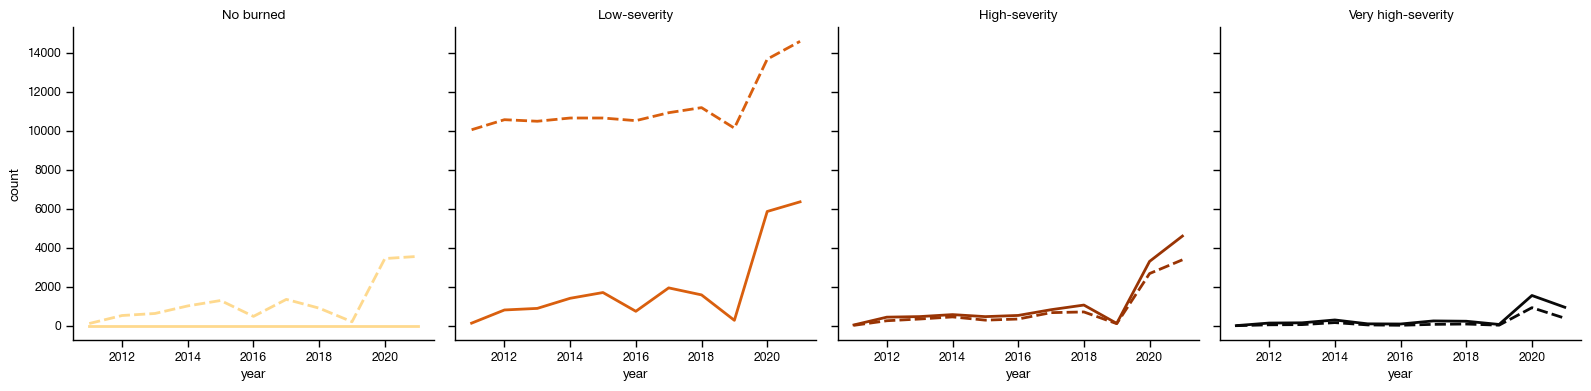

In [186]:
pal_colors = {
    "No burned": "#fed98e",
    "Low-severity": "#d95f0e",
    "High-severity": "#993404",
    "Very high-severity": "#090909",
}

# Count the observed classes
obs = df.groupby(["year", "observed_class"], as_index=False)["count"].sum()

# add the unburned ones
obs_unburned = pd.DataFrame(
    {
        "year": obs.year.unique(),
        "observed_class": "No burned",
        "count": 0,
    }
)
obs = pd.concat([obs, obs_unburned], ignore_index=True)
obs["type"] = "Observed"

# Count the simulated classes
sim = df.groupby(["year", "simulated_class"], as_index=False)["count"].sum()
sim["type"] = "Simulated"

combined = pd.concat(
    [
        obs.rename(columns={"observed_class": "class"}),
        sim.rename(columns={"simulated_class": "class"}),
    ]
)
combined.loc[
    (combined["type"] == "Simulated") & (combined["class"] == "Low-severity"),
    "count",
] += 10000

g = sns.FacetGrid(
    # data=combined[combined.dnbr_class_type != "No burned"],
    data=combined,
    col="class",
    sharey=True,
    sharex=True,
    height=4,
    aspect=1,
    # col_order=[100, 0, 1, 2, 3, 4],
    col_order=[
        "No burned",
        "Low-severity",
        "High-severity",
        "Very high-severity",
    ],
).map_dataframe(
    sns.lineplot,
    "year",
    "count",
    hue="class",
    style="type",
    linewidth=2,
    palette=pal_colors,
)

# Change the facet titles
g.set_titles(col_template="{col_name}")
# g.add_legend(title="Type")


# Save plot as PDF
plt.savefig(
    "../figs/dnbr_classification_simulated_vs_observed.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


## Fig 5: Large-scale prescribed burning reduces future burned area and wildfire smoke $PM_{2.5}$ (Panel B)

In [ ]:
import plotly.graph_objects as go

# Aggregate the data
# final_class = df[df.year == 2020]
final_class = df.groupby(["observed_class", "simulated_class"], as_index=False)[
    "count"
].sum()

# Desired order and colors
cat_order = ["No burned", "Low-severity", "High-severity", "Very high-severity"]
colors = ["#fed98e", "#d95f0e", "#993404", "#090909"]

# Add a tiny dummy row for "No burned" -> "No burned" to ensure the category exists on both sides
# This is a hack to prevent the Kaleido error
dummy_row = pd.DataFrame(
    {
        "observed_class": ["No burned"],
        "simulated_class": ["No burned"],
        "count": [0.001],  # Tiny value that won't be visible
    }
)
final_class = pd.concat([final_class, dummy_row], ignore_index=True)

# Remove actual zero counts but keep our dummy
final_class = final_class[final_class["count"] > 0]

# Ensure categories use the requested order
final_class["observed_class"] = pd.Categorical(
    final_class["observed_class"], categories=cat_order, ordered=True
)
final_class["simulated_class"] = pd.Categorical(
    final_class["simulated_class"], categories=cat_order, ordered=True
)

# Aggregate totals and compute percent shares per category (for labels)
# Exclude the dummy from percentage calculation
real_data = final_class[final_class["count"] > 0.01]
obs_totals = (
    real_data.groupby("observed_class", sort=False)["count"]
    .sum()
    .reindex(cat_order)
    .fillna(0)
)
sim_totals = (
    real_data.groupby("simulated_class", sort=False)["count"]
    .sum()
    .reindex(cat_order)
    .fillna(0)
)

obs_perc = (obs_totals / obs_totals.sum()) * 100
sim_perc = (sim_totals / sim_totals.sum()) * 100

# Build label strings with percentages
obs_labels = {cat: f"{cat} ({obs_perc.loc[cat]:.1f}%)" for cat in cat_order}
sim_labels = {cat: f"{cat} ({sim_perc.loc[cat]:.1f}%)" for cat in cat_order}

# Map labels to the dataframe values
final_class["observed_label"] = (
    final_class["observed_class"].astype(str).map(obs_labels)
)
final_class["simulated_label"] = (
    final_class["simulated_class"].astype(str).map(sim_labels)
)

# Map simulated class to integer codes for colouring
final_class["sim_code"] = final_class["simulated_class"].cat.codes

# Build colorscale
n = len(colors)
colorscale = [[i / (n - 1), c] for i, c in enumerate(colors)]

fig = go.Figure(
    go.Parcats(
        dimensions=[
            {
                "label": "Observed",
                "values": final_class["observed_label"].tolist(),
                "categoryarray": [obs_labels[c] for c in cat_order],
            },
            {
                "label": "Simulated",
                "values": final_class["simulated_label"].tolist(),
                "categoryarray": [sim_labels[c] for c in cat_order],
            },
        ],
        counts=final_class["count"].tolist(),
        line={
            "color": final_class["sim_code"].tolist(),
            "colorscale": colorscale,
            "shape": "hspline",
        },
        arrangement="freeform",
    )
)

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
)
fig.show()
# fig.write_image("../figs/parcats_dnbr_simulated_vs_observed_2020.svg")

/tmp/ipykernel_2813226/351052354.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2813226/351052354.py:45: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Fig S13: Limits to prescribed fire treatments with spillovers ($\leq$ 2 km) 

In [ ]:
from prescribed.estimate.simulations import sample_rx_years, simulation_data
from prescribed.utils import prepare_template

# Prepare simulation data
sim_data = simulation_data(
    template="/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif",
    land_type="/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather",
)
sim_data = sim_data[sim_data.land_type.isin([2])]

results = pd.read_csv("../data/results/att_conifers_dnbr_inmediate_new.csv")
results["land_type"] = 2

spillover_results = (
    pd.read_csv("../data/results/att_spillover_new.csv")
    .drop(columns="dist_treat", errors="ignore")
    .sort_values("year")
)

# Prepare template
template = prepare_template(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif",
    years=[2010, 2021],
)
template = template[template.year >= 2010]

# Prepare fire data
fire_data = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")
fire_data = fire_data[fire_data.year >= 2010]


list_df = []
for size in [500, 1000, 1500, 2000]:
    test_rx = sample_rx_years(
        template=template,
        treat_data=sim_data,
        estimates=results,
        fire_data=fire_data,
        spillovers=True,
        start_year=2010,
        sample_n=size,
        spillover_estimates=spillover_results,
        size_treatment=1000,
        spillover_size=1000,
    )
    df = test_rx.groupby("year_treat").grid_id.nunique().cumsum()
    df = df.reset_index()
    df.columns = ["year", "size"]

    df["treat_size"] = size

    list_df.append(df)


dfs = pd.concat(list_df, ignore_index=True)

<Axes: xlabel='Year', ylabel='Cumulative Treatments'>

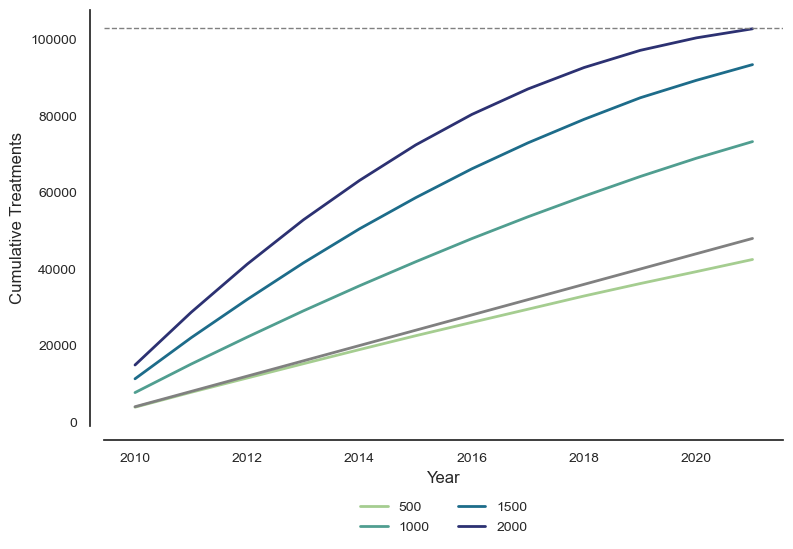

In [ ]:
# Set theme none for this plot
sns.set_theme(style="white")

no_spill = pd.DataFrame(
    {
        "year": np.arange(2010, 2022),
        "size": np.cumsum(np.repeat(4000, 12)),
        "treat_size": "No spillovers",
    }
)


fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=dfs,
    x="year",
    y="size",
    hue="treat_size",
    palette="crest",
    ax=ax,
    linewidth=2,
)


sns.lineplot(
    data=no_spill, x="year", y="size", color="gray", linewidth=2, ax=ax
)

# Add a horizontal line at y=1000
plt.axhline(y=103000, color="gray", linestyle="--", linewidth=1)
plt.legend(title="Treatment Size", loc="upper left")
plt.tight_layout()

# Move legend to the bottom of the plot outside the plotting area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    fontsize=10,
    frameon=False,
)

template_plots(
    ax,
    xlab="Year",
    ylab="Cumulative Treatments",
)

# # Save the plot
# plt.savefig(
#     "../figs/cumulative_treatments.pdf",
#     bbox_inches="tight",
#     dpi=400,
#     transparent=True,
# )


## Misc plots

In [ ]:
### Past plots
# Create nice percentile function for groupby aggregations
def percentile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "percentile_{:02.0f}".format(n * 100)
    return percentile_


# Calculate emissions from treatment (simulations) and observed data. We want to
# go from the event level to the state year leve, thus we need to aggregate for
# each simulation the sum of benefits and the cost of the policy. We take the
# mean cost because it's the same for all events in a simulation.

simulation_no_spill = sims.groupby(
    [
        "sim",
        "year",
    ],
    as_index=False,
).agg(
    {
        "policy_cost": "min",
        "simulated_sum_dnbr": "sum",
        "sum_dnbr": "sum",
    }
)


# Add the policy cost to benefits
simulation_no_spill["pm_policy"] = (
    simulation_no_spill.simulated_sum_dnbr.mul(preds_pm_all_fires)
    + simulation_no_spill.policy_cost
)
# + (4000 * 20 * preds_pm_all_fires)


simulation_no_spill["pm_observed"] = simulation_no_spill.sum_dnbr.mul(
    preds_pm_all_fires
)
simulation_no_spill["benefit"] = (
    simulation_no_spill.pm_observed - simulation_no_spill.pm_policy
)

# Merge the smoke data for all the years/sim at the state level
simulation_no_spill = simulation_no_spill.merge(
    sum_all_fires, on="year", how="inner"
)

simulation_no_spill = simulation_no_spill.assign(
    **{
        "benefit_cumsum": simulation_no_spill.benefit.cumsum(),
        "benefit_ratio": 1
        - (simulation_no_spill.pm_policy / simulation_no_spill.pm_observed),
        "ratio": 1
        - (
            simulation_no_spill.pm_policy.cumsum()
            / simulation_no_spill.pm_observed.cumsum()
        ),
    }
)

simulation_no_spill["type_rx"] = "No Spill"

# Plot the 0.05 and 0.95 quantiles for each discount rate and lag
ci_no_spill = (
    simulation_no_spill.groupby(["year"])
    .ratio.quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)

ci_no_spill["type_rx"] = "No Spill"


list_benefits = []
list_benefits_costs = []
for size in [500, 1000, 1500, 2000]:
    subset_sims = bens_sims[bens_sims.n_treats == size]

    simulation = subset_sims.groupby(
        [
            "sim",
            "year",
        ],
        as_index=False,
    ).agg(
        {
            "policy_cost": "min",
            "simulated_sum_dnbr": "sum",
            "sum_dnbr": "sum",
        }
    )

    # Add the policy cost to benefits
    simulation["pm_policy"] = (
        simulation.simulated_sum_dnbr.mul(preds_pm_all_fires)
        # + size * 20 * preds_pm_all_fires
        + simulation.policy_cost
    )

    simulation["pm_observed"] = simulation.sum_dnbr.mul(preds_pm_all_fires)

    simulation["benefit"] = simulation.pm_observed - simulation.pm_policy

    simulation = simulation.merge(sum_all_fires, on="year", how="inner")

    # Calculate benefits
    simulation = simulation.assign(
        **{
            "benefit_cumsum": simulation.benefit.cumsum(),
            "benefit_ratio": 1
            - (simulation.pm_policy / simulation.pm_observed),
            "ratio": 1
            - (simulation.pm_policy.cumsum() / simulation.pm_observed.cumsum()),
        }
    )

    simulation["type_rx"] = size
    list_benefits_costs.append(simulation)

    # Plot the 0.025 and 0.975 quantiles for each discount rate and lag
    ci = (
        simulation.groupby(["year"])
        .ratio.quantile([0.05, 0.5, 0.95])
        .unstack()
        .reset_index()
    )

    ci["type_rx"] = size
    list_benefits.append(ci)

list_benefits = pd.concat(list_benefits)
list_benefits_costs = pd.concat(list_benefits_costs)


# Calculate costs in 2010
list_benefits_costs = pd.concat([list_benefits_costs, simulation_no_spill])

# Calculate cost for the first year of treatment
cost_2010 = (
    (
        list_benefits_costs.groupby(["type_rx"], as_index=False)
        .policy_cost.median()
        .assign(**{"year": 2010})
    )
    .merge(sum_all_fires[["year", "smoke_pm"]].drop_duplicates(), on="year")
    .assign(
        **{
            "0.5": lambda x: -1 * ((x.smoke_pm + x.policy_cost) / x.smoke_pm),
            "0.05": None,
            "0.95": None,
        }
    )
)
cost_2010 = cost_2010[["year", "0.05", "0.5", "0.95", "type_rx"]]
cost_2010.columns = list_benefits.columns.tolist()


# Create nice percentile function for groupby aggregations
def percentile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "percentile_{:02.0f}".format(n * 100)
    return percentile_


# Calculate emissions from treatment (simulations) and observed data. We want to
# go from the event level to the state year leve, thus we need to aggregate for
# each simulation the sum of benefits and the cost of the policy. We take the
# mean cost because it's the same for all events in a simulation.

simulation_no_spill = sims.groupby(
    [
        "sim",
        "year",
    ],
    as_index=False,
).agg(
    {
        "benefit": "sum",
        "policy_cost": "mean",
        "preds_sim_pm": "sum",
        "preds_pm": "sum",
    }
)


# Add the policy cost to benefits
simulation_no_spill["preds_sim_pm_cost"] = (
    simulation_no_spill.benefit - simulation_no_spill.policy_cost
)
simulation_no_spill["pred_pm_total"] = (
    simulation_no_spill.preds_sim_pm + simulation_no_spill.policy_cost
)

# Merge the smoke data for all the years/sim at the state level
simulation_no_spill = simulation_no_spill.merge(
    sum_all_fires, on="year", how="inner"
)

simulation_no_spill = simulation_no_spill.assign(
    **{
        "benefit_cumsum": simulation_no_spill.preds_sim_pm_cost.cumsum(),
        "benefit_ratio": (
            simulation_no_spill.preds_sim_pm_cost / simulation_no_spill.preds_pm
        ),
        "ratio": (
            simulation_no_spill.preds_sim_pm_cost.cumsum()
            / simulation_no_spill.smoke_pm.cumsum()
        ),
    }
)

simulation_no_spill["type_rx"] = "No Spill"

# Plot the 0.05 and 0.95 quantiles for each discount rate and lag
ci_no_spill = (
    simulation_no_spill.groupby(["year"])
    .ratio.quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)

ci_no_spill["type_rx"] = "No Spill"


list_benefits = []
list_benefits_costs = []
for size in [500, 1000, 1500, 2000]:
    subset_sims = bens_sims[bens_sims.n_treats == size]

    simulation = (
        subset_sims
        # subset_sims[subset_sims.event_id.isin(smoke_linked.event_id.tolist())]
        .groupby(
            [
                "sim",
                "year",
            ],
            as_index=False,
        ).agg(
            {
                "benefit": "sum",
                "policy_cost": "min",
                "preds_sim_pm": "sum",
                "preds_pm": "sum",
            }
        )
    )

    # Add the policy cost to benefits
    simulation["preds_sim_pm_cost"] = (
        simulation.benefit - simulation.policy_cost
    )

    simulation["pred_pm_total"] = (
        simulation.preds_sim_pm + simulation.policy_cost
    )

    simulation = simulation.merge(sum_all_fires, on="year", how="inner")

    # Calculate benefits
    simulation = simulation.assign(
        **{
            "benefit_cumsum": simulation.preds_sim_pm_cost.cumsum(),
            "benefit_ratio": (
                simulation.preds_sim_pm_cost / simulation.preds_pm
            ),
            "ratio": (
                simulation.preds_sim_pm_cost.cumsum()
                / simulation.smoke_pm.cumsum()
            ),
        }
    )

    simulation["type_rx"] = size
    list_benefits_costs.append(simulation)

    # Plot the 0.025 and 0.975 quantiles for each discount rate and lag
    ci = (
        simulation.groupby(["year"])
        .ratio.quantile([0.05, 0.5, 0.95])
        .unstack()
        .reset_index()
    )

    ci["type_rx"] = size
    list_benefits.append(ci)

list_benefits = pd.concat(list_benefits)
list_benefits_costs = pd.concat(list_benefits_costs)


# Calculate costs in 2010
list_benefits_costs = pd.concat([list_benefits_costs, simulation_no_spill])

# Calculate cost for the first year of treatment
cost_2010 = (
    (
        list_benefits_costs.groupby(["type_rx"], as_index=False)
        .policy_cost.median()
        .assign(**{"year": 2010})
    )
    .merge(sum_all_fires[["year", "smoke_pm"]].drop_duplicates(), on="year")
    .assign(
        **{
            "0.5": lambda x: -1 * ((x.smoke_pm + x.policy_cost) / x.smoke_pm),
            "0.05": None,
            "0.95": None,
        }
    )
)
cost_2010 = cost_2010[["year", "0.05", "0.5", "0.95", "type_rx"]]
cost_2010.columns = list_benefits.columns.tolist()
## Fig 5: Large-scale prescribed burning reduces future burned area and wildfire smoke $PM_{2.5}$ (Panel C)
merged_df = pd.concat([list_benefits, ci_no_spill, cost_2010])

# Rename the columns for clarity
merged_df.columns = ["year", "p_0.05", "p_0.5", "p_0.95", "type_rx"]

# Make it match with other colors for spillovers size
palette_dict = {
    "No Spill": "#6e6e6f",
    500: sns.color_palette(palette="crest", n_colors=4)[0],
    1000: sns.color_palette(palette="crest", n_colors=4)[1],
    1500: sns.color_palette(palette="crest", n_colors=4)[2],
    2000: sns.color_palette(palette="crest", n_colors=4)[3],
}

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=merged_df,
    x="year",
    y="p_0.5",
    hue="type_rx",
    linewidth=2,
    palette=palette_dict,
    legend=False,
    ax=ax,
)

# Add all years to the x-axis
ax.set_xticks(np.arange(2010, 2022, 1))
ax.set_xticklabels(np.arange(2010, 2022, 1), rotation=45)

template_plots(
    ax,
    xlab="Treatment year",
    ylab="Cumulative share of PM$_{2.5}$ concentrations savings \n to observed emissions \n ($\\frac{PM_{obs}- PM_{sim}}{PM_{obs}}$)",
)

# ax.set_ylim(-2, 0.5)

# Add a horizontal line at 0.1
ax.axhline(
    y=0, color="gray", linestyle="--", linewidth=1, label="10% threshold"
)

# # Save the plot as a PDF
# plt.savefig(
#     "../figs/benefits_share_pm_ratio.pdf",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )

# plt.show()
fig, ax = plt.subplots(figsize=(1.5, 6))

new_data = merged_df[merged_df.year == 2021]
new_data["type_rx_idx"] = [1, 2, 3, 4, 5]

sns.pointplot(
    data=new_data,
    x="type_rx_idx",
    y="p_0.5",
    hue="type_rx",
    palette=palette_dict,
    ax=ax,
    markersize=4,
    markers="o",
    legend=False,
)

# Add error bars using the 0.05 and 0.95 quantiles
for idx, row in new_data.iterrows():
    lower_error = row["p_0.5"] - row["p_0.05"]
    upper_error = row["p_0.95"] - row["p_0.5"]
    ax.errorbar(
        row["type_rx_idx"] - 1,  # Adjust x position for error bars
        row["p_0.5"],  # Central value
        yerr=[[lower_error], [upper_error]],  # Tuple of lower and upper errors
        fmt="none",
        color=palette_dict[row["type_rx"]],
        capsize=0,
    )

# Add a horizontal line at 0.1
ax.axhline(
    y=0, color="gray", linestyle="--", linewidth=1, label="10% threshold"
)
template_plots(ax, xlab="", ylab="")

# Set the y-axis limits
ax.set_ylim(-0.1, 0.5)

# # Save the plot as a PDF
# plt.savefig(
#     "../figs/benefits_share_pm_ratio_2020_ci.pdf",
#     bbox_inches="tight",
#     dpi=400,
#     transparent=True,
# )m